In [ ]:
import graph_tool.all as gt
from graph_tool import generation
from graph_tool.all import Graph
import pandas as pd
import networkx as nx
import re
from collections import Counter
import numpy as np
import random as rd
import pickle as pk
import random 
import json
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42   # TrueType fonts (editable)
mpl.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt 
import seaborn as sns



In [2]:
from scipy import stats
def overlap_set(setA, setB,background):    
    """
    Accepts to lists
    M is the population size (previously N)
    n is the number of successes in the population
    N is the sample size (previously n)
    x is still the number of drawn “successes”
    """
    M= background #total number of exposures in chem_gene_cleaned
    n= len(setA)
    N= len(setB)
    x= len(setA.intersection(setB))
    return str(stats.hypergeom.sf(x-1, M, n, N))

from scipy.stats import mannwhitneyu
from statsmodels.sandbox.stats.multicomp import multipletests
def fdr_adjustment(list_of_pvals,alpha):    
    return multipletests(list_of_pvals,alpha=alpha,method='fdr_bh')[1] #the benjamin hochberg method is used

In [3]:
#Let's import the chemical-gene interactions from CTD (downloaded on 5th April 2021)
chem_gene_df = pd.read_csv("input/CTD/CTD_chem_gene_ixns.tsv",delimiter= '\t', skipinitialspace=True)
#Here, we filter for only the interactions that regards the H. Sapiens
chem_homo = chem_gene_df[(chem_gene_df['Organism'] == 'Homo sapiens')]

In [4]:
chem_gene = {}
for i,v in chem_homo.iterrows():
    try:
        chem_gene[v["ChemicalID"]] |= {v["GeneSymbol"]}
    except KeyError as e:
        chem_gene[v["ChemicalID"]] = set([v["GeneSymbol"]])

In [5]:
# Drop rows with missing GeneSymbols
chem_homo.dropna(subset=['GeneSymbol'], inplace=True)

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_27689/2507042359.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chem_homo.dropna(subset=['GeneSymbol'], inplace=True)


In [6]:
# Get unique entities
chemicals = chem_homo['ChemicalID'].unique()
genes = chem_homo['GeneSymbol'].unique()

In [7]:
# Create a dataframe for edges
# We utilize pandas factorize to quickly turn strings into ID integers
# Note: We need to ensure Chemical IDs and Gene IDs don't overlap in the integer space
num_chemicals = len(chemicals)
num_genes = len(genes)

# Map ChemicalID to 0 ... num_chemicals-1
chem_map = {name: i for i, name in enumerate(chemicals)}
# Map GeneSymbol to num_chemicals ... num_chemicals+num_genes-1
gene_map = {name: i + num_chemicals for i, name in enumerate(genes)}

# Create edge list using map
# This is much faster than iterating rows
edges = chem_homo[['ChemicalID', 'GeneSymbol']].copy()
edges['source'] = edges['ChemicalID'].map(chem_map)
edges['target'] = edges['GeneSymbol'].map(gene_map)
edge_list = edges[['source', 'target']].values

In [9]:
# 3. Build Graph-tool Graph Directly (Bulk Load)
print("Building Graph-tool graph...")
g = gt.Graph(directed=False)

# Add all edges at once (Super fast C++ backend)
g.add_edge_list(edge_list)

# 4. Add Properties (Optional, but useful for reference)
# Create a property map for labels and bipartite type
v_name = g.new_vertex_property("string")
v_bipartite = g.new_vertex_property("string")

# We can fill these properties efficiently
# (For 1M edges, a simple loop over unique nodes is fine, 
# but we can map the arrays directly if needed)
for name, idx in chem_map.items():
    v = g.vertex(idx)
    v_name[v] = str(name)
    v_bipartite[v] = "exposure"

for name, idx in gene_map.items():
    v = g.vertex(idx)
    v_name[v] = str(name)
    v_bipartite[v] = "gene"

g.vp["name"] = v_name
g.vp["bipartite"] = v_bipartite

print(f"Graph constructed: {g.num_vertices()} nodes, {g.num_edges()} edges.")

Building Graph-tool graph...
Graph constructed: 35466 nodes, 938634 edges.


In [12]:
# 5. Optimized SBM Inference
# DO NOT use gt.BlockState(g) directly for large graphs.
# Use minimize_blockmodel_dl to find a 'warm start' state.
print("Minimizing description length (finding initial model)...")

# This function uses a fast agglomerative heuristic to find a good B (number of groups)
state = gt.minimize_blockmodel_dl(g)

# Returns the number of blocks that actually contain nodes
print(f"Initial block count found: {state.get_nonempty_B()}")

Minimizing description length (finding initial model)...
Initial block count found: 181


In [13]:
# 6. MCMC Equilibration
# Now we refine the state found above. 
# Since we are already near the optimum, we need fewer sweeps.
print("Running MCMC equilibration...")

# We use the previous state as the starting point
dS, nattempts, nmoves = state.multiflip_mcmc_sweep(niter=100) 
print("Change in description length:", dS)

Running MCMC equilibration...
Change in description length: 3890.641348737878


In [14]:
# Collect partitions
bs = []

def collect_partitions(s):
    bs.append(s.b.a.copy())

# Equilibrate and collect
# 'force_niter' forces it to run even if delta is small
gt.mcmc_equilibrate(state, force_niter=1000, mcmc_args=dict(niter=10),
                    callback=collect_partitions)

(2397949.2928149314, 405917554, 31573597)

In [18]:
# 7. Disambiguate and get Mode
print("Calculating partition mode...")
pmode = gt.PartitionModeState(bs, converge=True)
hard_partition = pmode.get_max(g).a

Calculating partition mode...


In [19]:
# 8. Map back to labels (Example)
# Create a dictionary mapping the original string ID to the block ID
final_partition_map = {}

# Combine our previous maps to decode
inv_chem_map = {v: k for k, v in chem_map.items()}
inv_gene_map = {v: k for k, v in gene_map.items()}

for node_idx in range(g.num_vertices()):
    block_id = hard_partition[node_idx]
    
    if node_idx < num_chemicals:
        original_id = inv_chem_map.get(node_idx)
    else:
        original_id = inv_gene_map.get(node_idx)
        
    if original_id:
        final_partition_map[original_id] = int(block_id)

print("Done! Sample partition:", list(final_partition_map.items())[:5])

Done! Sample partition: [('C534883', 0), ('C004822', 1), ('C039775', 44), ('C534422', 3), ('C496879', 4)]


In [22]:
bipartite_sbm_clustering_dict = {}
for com_partition in set(final_partition_map.values()):
    node_list = []
    for node,part in final_partition_map.items():   
        if com_partition==part:
            node_list.append(node)
    bipartite_sbm_clustering_dict[com_partition] = node_list

print(len(bipartite_sbm_clustering_dict))

191


In [ ]:
with open('output/bipartite_sbm_clustering_dict.pickle', 'wb') as handle:
    pk.dump(bipartite_sbm_clustering_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

In [8]:
with open ('output/bipartite_sbm_clustering_dict.pickle', 'rb') as fp:
    bipartite_sbm_clustering_dict = pk.load(fp)


In [9]:
#SBM identifies partitions within the two bipartite sides (so communities with only exposures and with only genes)

bipartite_sbm_clustering_dict_exposures = {}
bipartite_sbm_clustering_dict_genes = {}
for com_partition, nodes in bipartite_sbm_clustering_dict.items():
    exposure_list = []
    gene_list = []
    for node in nodes:
        if node in chem_map:
            exposure_list.append(node)
        elif node in gene_map:
            gene_list.append(node)
    if len(exposure_list)>0:
        bipartite_sbm_clustering_dict_exposures[com_partition] = exposure_list
    else:
        bipartite_sbm_clustering_dict_genes[com_partition] = gene_list

print(len(bipartite_sbm_clustering_dict_exposures))
print(len(bipartite_sbm_clustering_dict_genes))

102
89


In [ ]:
#Let's compare these communities with the previous Louvain ones and Infomap ones

In [34]:
#Louvain

In [54]:
with open ('output/Communities/Louvain/weighted_ji_fine_grained_communities_dict.pickle', 'rb') as fp:
    Louvain_fine_grained_communities_dict = pk.load(fp)

with open('output/Communities/Louvain/gg_Louvain_fine_grained_dict.pickle', 'rb') as handle:
    gg_Louvain_fine_grained_dict = pk.load(handle)

In [11]:
bipartite_sbm_clustering_dict_exposures_louvain_fg_pval = {}
bipartite_sbm_clustering_dict_exposures_louvain_fg_fdr = {}
sig_overlapping_exposures_louvain_fg_communities = []

bipartite_sbm_clustering_dict_genes_louvain_fg_pval = {}
bipartite_sbm_clustering_dict_genes_louvain_fg_fdr = {}
sig_overlapping_genes_louvain_fg_communities = []

for com_partition,explist in bipartite_sbm_clustering_dict_exposures.items():
    for com_louvain, louvain_explist in Louvain_fine_grained_communities_dict.items():
        overlap_pval = overlap_set(set(explist), set(louvain_explist), len(chem_map))
        if str(overlap_pval)!='nan':
            bipartite_sbm_clustering_dict_exposures_louvain_fg_pval[(com_partition,com_louvain)] = float(overlap_pval)
pvals = list(bipartite_sbm_clustering_dict_exposures_louvain_fg_pval.values())
fdrs = fdr_adjustment(pvals,0.05)
for i,key in enumerate(bipartite_sbm_clustering_dict_exposures_louvain_fg_pval.keys()):
    bipartite_sbm_clustering_dict_exposures_louvain_fg_fdr[key] = fdrs[i]
for com_partition in bipartite_sbm_clustering_dict_exposures.keys():
    for com_pair,fdr in bipartite_sbm_clustering_dict_exposures_louvain_fg_fdr.items():
        if com_partition==com_pair[0]:
            if fdr<=0.05:
                sig_overlapping_exposures_louvain_fg_communities.append(com_partition)



for com_partition,genelist in bipartite_sbm_clustering_dict_genes.items():
    for com_louvain, louvain_genelist in gg_Louvain_fine_grained_dict.items():
        overlap_pval = overlap_set(set(genelist), set(louvain_genelist), len(gene_map))
        if str(overlap_pval)!='nan':
            bipartite_sbm_clustering_dict_genes_louvain_fg_pval[(com_partition,com_louvain)] = float(overlap_pval)
pvals = list(bipartite_sbm_clustering_dict_genes_louvain_fg_pval.values())
fdrs = fdr_adjustment(pvals,0.05)
for i,key in enumerate(bipartite_sbm_clustering_dict_genes_louvain_fg_pval.keys()):
    bipartite_sbm_clustering_dict_genes_louvain_fg_fdr[key] = fdrs[i]

for com_partition in bipartite_sbm_clustering_dict_genes.keys():
    for com_pair,fdr in bipartite_sbm_clustering_dict_genes_louvain_fg_fdr.items():
        if com_partition==com_pair[0]:
            if fdr<=0.05:
                sig_overlapping_genes_louvain_fg_communities.append(com_partition)

print(len(set(sig_overlapping_exposures_louvain_fg_communities)))
print(len(set(sig_overlapping_genes_louvain_fg_communities)))

85
82


In [55]:
#Middle
with open ('output/Communities/Louvain/weighted_ji_middle_communities_dict.pickle', 'rb') as fp:
    Louvain_middle_communities_dict = pk.load(fp)

with open('output/Communities/Louvain/gg_Louvain_middle_dict.pickle', 'rb') as handle:
    gg_Louvain_middle_dict = pk.load(handle)

In [13]:
bipartite_sbm_clustering_dict_exposures_louvain_m_pval = {}
bipartite_sbm_clustering_dict_exposures_louvain_m_fdr = {}
sig_overlapping_exposures_louvain_m_communities = []

bipartite_sbm_clustering_dict_genes_louvain_m_pval = {}
bipartite_sbm_clustering_dict_genes_louvain_m_fdr = {}
sig_overlapping_genes_louvain_m_communities = []

for com_partition,explist in bipartite_sbm_clustering_dict_exposures.items():
    for com_louvain, louvain_explist in Louvain_middle_communities_dict.items():
        overlap_pval = overlap_set(set(explist), set(louvain_explist), len(chem_map))
        if str(overlap_pval)!='nan':
            bipartite_sbm_clustering_dict_exposures_louvain_m_pval[(com_partition,com_louvain)] = float(overlap_pval)
pvals = list(bipartite_sbm_clustering_dict_exposures_louvain_m_pval.values())
fdrs = fdr_adjustment(pvals,0.05)
for i,key in enumerate(bipartite_sbm_clustering_dict_exposures_louvain_m_pval.keys()):
    bipartite_sbm_clustering_dict_exposures_louvain_m_fdr[key] = fdrs[i]
for com_partition in bipartite_sbm_clustering_dict_exposures.keys():
    for com_pair,fdr in bipartite_sbm_clustering_dict_exposures_louvain_m_fdr.items():
        if com_partition==com_pair[0]:
            if fdr<=0.05:
                sig_overlapping_exposures_louvain_m_communities.append(com_partition)



for com_partition,genelist in bipartite_sbm_clustering_dict_genes.items():
    for com_louvain, louvain_genelist in gg_Louvain_middle_dict.items():
        overlap_pval = overlap_set(set(genelist), set(louvain_genelist), len(gene_map))
        if str(overlap_pval)!='nan':
            bipartite_sbm_clustering_dict_genes_louvain_m_pval[(com_partition,com_louvain)] = float(overlap_pval)
pvals = list(bipartite_sbm_clustering_dict_genes_louvain_m_pval.values())
fdrs = fdr_adjustment(pvals,0.05)
for i,key in enumerate(bipartite_sbm_clustering_dict_genes_louvain_m_pval.keys()):
    bipartite_sbm_clustering_dict_genes_louvain_m_fdr[key] = fdrs[i]
for com_partition in bipartite_sbm_clustering_dict_genes.keys():
    for com_pair,fdr in bipartite_sbm_clustering_dict_genes_louvain_m_fdr.items():
        if com_partition==com_pair[0]:
            if fdr<=0.05:
                sig_overlapping_genes_louvain_m_communities.append(com_partition)

print(len(set(sig_overlapping_exposures_louvain_m_communities)))
print(len(set(sig_overlapping_genes_louvain_m_communities)))

80
76


In [56]:
#Broad
with open ('output/Communities/Louvain/weighted_ji_broad_communities_dict.pickle', 'rb') as fp:
    Louvain_broad_communities_dict = pk.load(fp)

with open('output/Communities/Louvain/gg_Louvain_broad_dict.pickle', 'rb') as handle:
    gg_Louvain_broad_dict = pk.load(handle)

In [15]:
bipartite_sbm_clustering_dict_exposures_louvain_b_pval = {}
bipartite_sbm_clustering_dict_exposures_louvain_b_fdr = {}
sig_overlapping_exposures_louvain_b_communities = []

bipartite_sbm_clustering_dict_genes_louvain_b_pval = {}
bipartite_sbm_clustering_dict_genes_louvain_b_fdr = {}
sig_overlapping_genes_louvain_b_communities = []

for com_partition,explist in bipartite_sbm_clustering_dict_exposures.items():
    for com_louvain, louvain_explist in Louvain_broad_communities_dict.items():
        overlap_pval = overlap_set(set(explist), set(louvain_explist), len(chem_map))
        if str(overlap_pval)!='nan':
            bipartite_sbm_clustering_dict_exposures_louvain_b_pval[(com_partition,com_louvain)] = float(overlap_pval)
pvals = list(bipartite_sbm_clustering_dict_exposures_louvain_b_pval.values())
fdrs = fdr_adjustment(pvals,0.05)
for i,key in enumerate(bipartite_sbm_clustering_dict_exposures_louvain_b_pval.keys()):
    bipartite_sbm_clustering_dict_exposures_louvain_b_fdr[key] = fdrs[i]
for com_partition in bipartite_sbm_clustering_dict_exposures.keys():
    for com_pair,fdr in bipartite_sbm_clustering_dict_exposures_louvain_b_fdr.items():
        if com_partition==com_pair[0]:
            if fdr<=0.05:
                sig_overlapping_exposures_louvain_b_communities.append(com_partition)



for com_partition,genelist in bipartite_sbm_clustering_dict_genes.items():
    for com_louvain, louvain_genelist in gg_Louvain_broad_dict.items():
        overlap_pval = overlap_set(set(genelist), set(louvain_genelist), len(gene_map))
        if str(overlap_pval)!='nan':
            bipartite_sbm_clustering_dict_genes_louvain_b_pval[(com_partition,com_louvain)] = float(overlap_pval)
pvals = list(bipartite_sbm_clustering_dict_genes_louvain_b_pval.values())
fdrs = fdr_adjustment(pvals,0.05)
for i,key in enumerate(bipartite_sbm_clustering_dict_genes_louvain_b_pval.keys()):
    bipartite_sbm_clustering_dict_genes_louvain_b_fdr[key] = fdrs[i]
for com_partition in bipartite_sbm_clustering_dict_genes.keys():
    for com_pair,fdr in bipartite_sbm_clustering_dict_genes_louvain_b_fdr.items():
        if com_partition==com_pair[0]:
            if fdr<=0.05:
                sig_overlapping_genes_louvain_b_communities.append(com_partition)

print(len(set(sig_overlapping_exposures_louvain_b_communities)))
print(len(set(sig_overlapping_genes_louvain_b_communities)))

28
0


In [16]:

dicts = {
    "FG": bipartite_sbm_clustering_dict_exposures_louvain_fg_fdr,
    "M":  bipartite_sbm_clustering_dict_exposures_louvain_m_fdr,
    "B":  bipartite_sbm_clustering_dict_exposures_louvain_b_fdr,
}

records = []

for method, D in dicts.items():
    for (sbm, uni), fdr in D.items():
        records.append((sbm, f"{method}:{uni}", float(fdr)))

df = pd.DataFrame(records, columns=["SBM", "Community", "FDR"])

M = df.pivot(index="SBM", columns="Community", values="FDR")
M = M.fillna(1.0)
M_safe = M.copy()
M_safe[M_safe <= 0] = 1e-300 

S = -np.log10(M_safe)
S[S > 50] = 50

from scipy.optimize import linear_sum_assignment

# Cost = negative significance → maximize diagonal signal
cost = -S.values

row_ind, col_ind = linear_sum_assignment(cost)

ordered_cols = S.columns[col_ind]
S = S[ordered_cols]
M = M[ordered_cols]

methods = S.columns.str.split(":").str[0]

method_order = ["FG", "M", "B"]
ordered_cols = (
    S.columns[methods == "FG"].tolist() +
    S.columns[methods == "M"].tolist() +
    S.columns[methods == "B"].tolist()
)

S = S[ordered_cols]
M = M[ordered_cols]


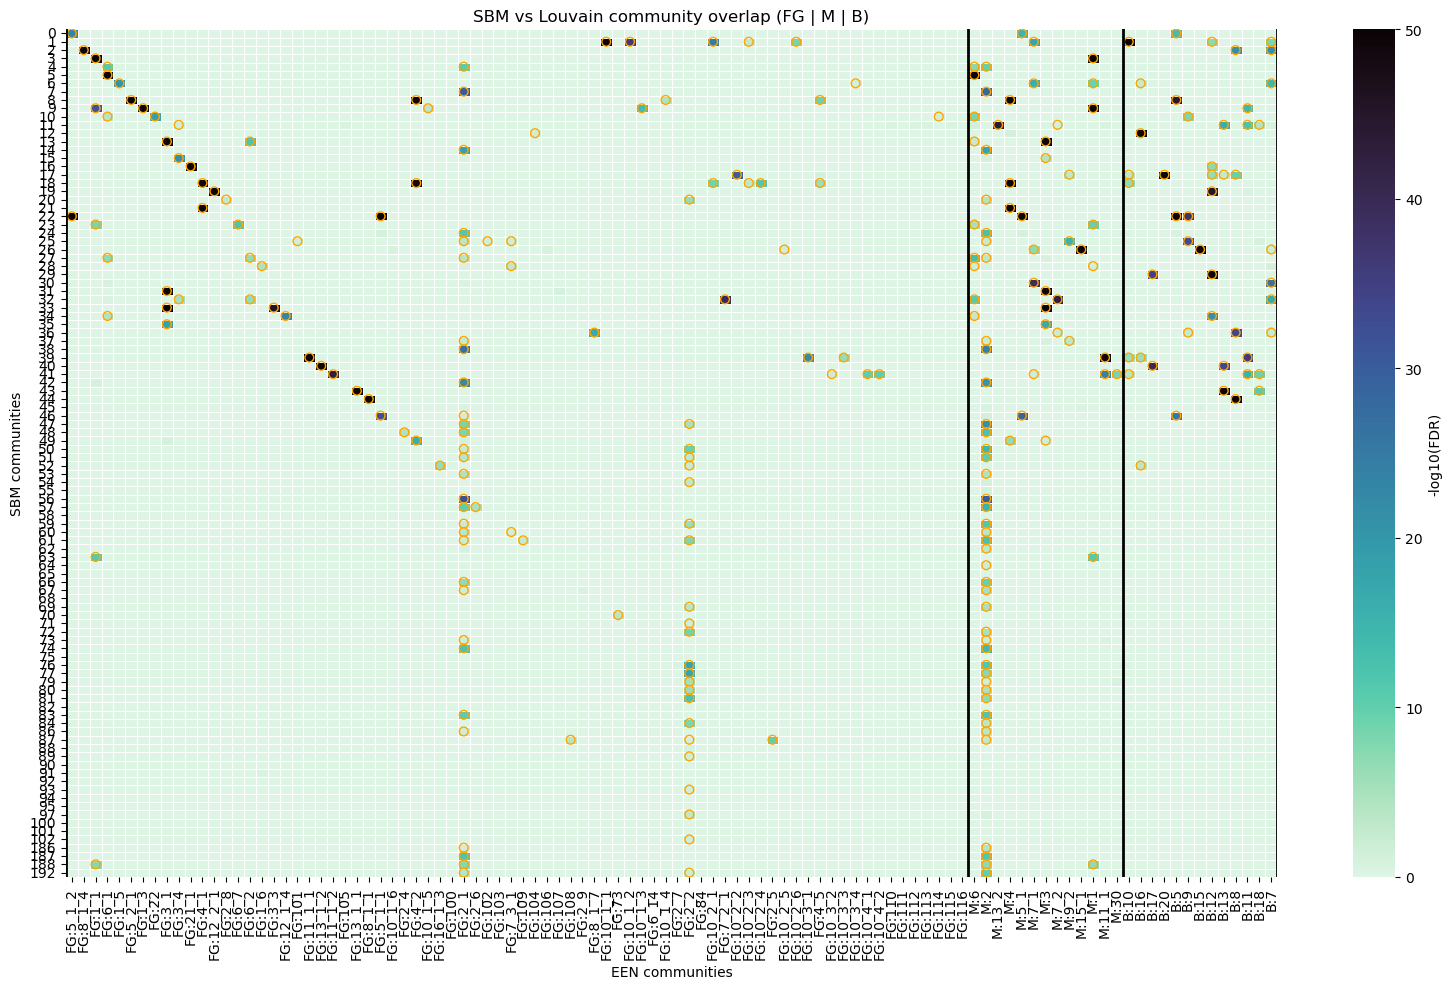

In [206]:
sig = (M < 0.05)

plt.figure(figsize=(16,10))

ax = sns.heatmap(
    S,
    cmap="mako_r",
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"label": "-log10(FDR)"},
    xticklabels=True,
    yticklabels=True
)

# ---- Overlay significance circles (FDR < 0.05) ----
for i in range(S.shape[0]):        # SBM rows
    for j in range(S.shape[1]):    # FG|M|B columns
        if sig.iloc[i, j]:
            ax.scatter(
                j + 0.5, i + 0.5,
                s=40,
                facecolors='none',
                edgecolors='orange',
                linewidths=1
            )

# ---- Draw method separators ----
x = 0
for method in ["FG","M","B"]:
    n = sum(S.columns.str.startswith(method))
    plt.axvline(x, color="black", lw=2)
    x += n
plt.axvline(x, color="black", lw=2)


plt.title("SBM vs Louvain community overlap (FG | M | B)")
plt.xlabel("EEN communities")
plt.ylabel("SBM communities")

plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('output/SBM_exposures_Louvain_Heatmap.pdf', format='pdf', dpi=300, bbox_inches="tight")
plt.savefig('output/SBM_exposures_Louvain_Heatmap.png', format='png', dpi=300, bbox_inches="tight")
plt.show()

In [17]:

# -----------------------------
# Build export dataframe
# -----------------------------

export_records = []

for i, sbm in enumerate(S.index):
    for j, community in enumerate(S.columns):
        
        raw_fdr = M.loc[sbm, community]
        
        # Safe version used for log transform
        safe_fdr = raw_fdr if raw_fdr > 0 else 1e-300
        
        neglog_raw = -np.log10(safe_fdr)
        neglog_capped = S.loc[sbm, community]
        significance = raw_fdr < 0.05
        
        export_records.append({
            "SBM_community": sbm,
            "EEN_community": community,
            "Plot_row_index": i,
            "Plot_column_index": j,
            "Raw_FDR": raw_fdr,
            "Safe_FDR_for_log": safe_fdr,
            "-log10_FDR_raw": neglog_raw,
            "-log10_FDR_capped_at_50": neglog_capped,
            "Significant_FDR<0.05": significance
        })

df_heatmap_source = pd.DataFrame(export_records)

print("Total cells exported:", len(df_heatmap_source))

# -----------------------------
# Save to single Excel sheet
# -----------------------------

out_file = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(out_file,
                    engine="openpyxl",
                    mode="a",
                    if_sheet_exists="replace") as writer:

    df_heatmap_source.to_excel(
        writer,
        sheet_name="SF27A",
        index=False
    )

print("Heatmap source data saved successfully.")

Total cells exported: 10404
Heatmap source data saved successfully.


In [26]:

dicts = {
    "FG": bipartite_sbm_clustering_dict_genes_louvain_fg_fdr,
    "M":  bipartite_sbm_clustering_dict_genes_louvain_m_fdr,
    "B":  bipartite_sbm_clustering_dict_genes_louvain_b_fdr,
}

records = []

for method, D in dicts.items():
    for (sbm, uni), fdr in D.items():
        records.append((sbm, f"{method}:{uni}", float(fdr)))

df = pd.DataFrame(records, columns=["SBM", "Community", "FDR"])

M = df.pivot(index="SBM", columns="Community", values="FDR")
M = M.fillna(1.0)
M_safe = M.copy()
M_safe[M_safe <= 0] = 1e-300 

S = -np.log10(M_safe)
S[S > 50] = 50

from scipy.optimize import linear_sum_assignment

# Cost = negative significance → maximize diagonal signal
cost = -S.values

row_ind, col_ind = linear_sum_assignment(cost)

ordered_cols = S.columns[col_ind]
S = S[ordered_cols]
M = M[ordered_cols]

methods = S.columns.str.split(":").str[0]

method_order = ["FG", "M", "B"]
ordered_cols = (
    S.columns[methods == "FG"].tolist() +
    S.columns[methods == "M"].tolist() +
    S.columns[methods == "B"].tolist()
)

S = S[ordered_cols]
M = M[ordered_cols]

sig = (M < 0.05)

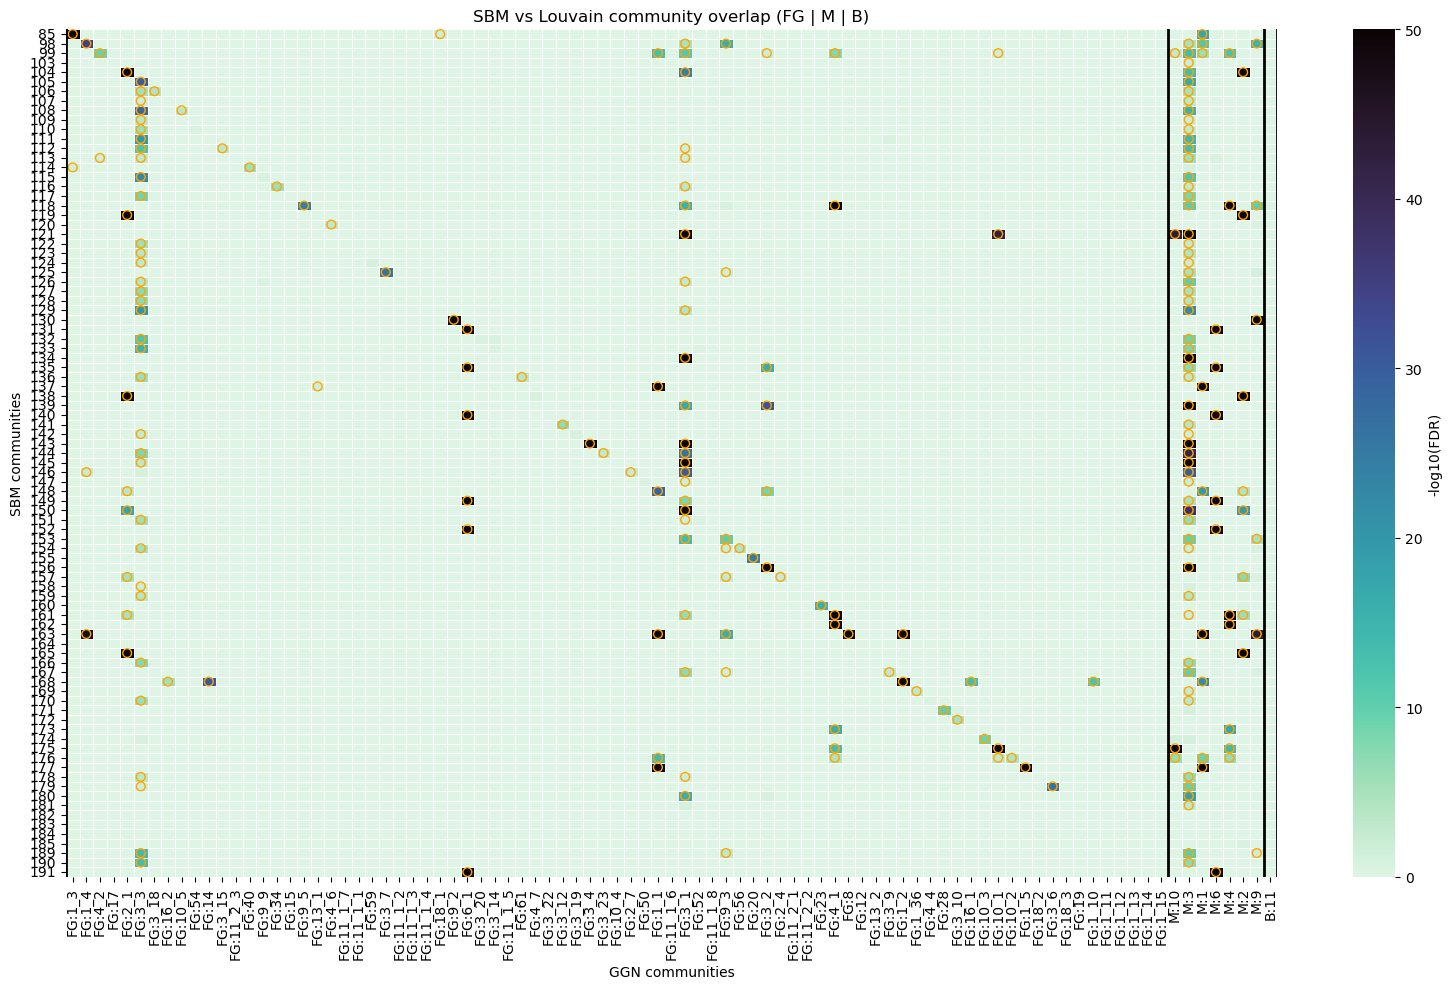

In [31]:


plt.figure(figsize=(16,10))

ax = sns.heatmap(
    S,
    cmap="mako_r",
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"label": "-log10(FDR)"},
    xticklabels=True,
    yticklabels=True
)

# ---- Overlay significance circles (FDR < 0.05) ----
for i in range(S.shape[0]):        # SBM rows
    for j in range(S.shape[1]):    # FG|M|B columns
        if sig.iloc[i, j]:
            ax.scatter(
                j + 0.5, i + 0.5,
                s=40,
                facecolors='none',
                edgecolors='orange',
                linewidths=1
            )

# ---- Draw method separators ----
x = 0
for method in ["FG","M","B"]:
    n = sum(S.columns.str.startswith(method))
    plt.axvline(x, color="black", lw=2)
    x += n
plt.axvline(x, color="black", lw=2)


plt.title("SBM vs Louvain community overlap (FG | M | B)")
plt.xlabel("GGN communities")
plt.ylabel("SBM communities")

plt.xticks(rotation=90)
plt.tight_layout()
#plt.savefig('output/Figures/SBM_genes_Louvain_Heatmap.pdf', format='pdf', dpi=300, bbox_inches="tight")
#plt.savefig('output/Figures/SBM_genes_Louvain_Heatmap.png', format='png', dpi=300, bbox_inches="tight")
plt.show()


In [32]:

# -----------------------------
# Build export dataframe
# -----------------------------

export_records = []

for i, sbm in enumerate(S.index):
    for j, community in enumerate(S.columns):
        
        raw_fdr = M.loc[sbm, community]
        
        # Safe version used for log transform
        safe_fdr = raw_fdr if raw_fdr > 0 else 1e-300
        
        neglog_raw = -np.log10(safe_fdr)
        neglog_capped = S.loc[sbm, community]
        significance = raw_fdr < 0.05
        
        export_records.append({
            "SBM_community": sbm,
            "EEN_community": community,
            "Plot_row_index": i,
            "Plot_column_index": j,
            "Raw_FDR": raw_fdr,
            "Safe_FDR_for_log": safe_fdr,
            "-log10_FDR_raw": neglog_raw,
            "-log10_FDR_capped_at_50": neglog_capped,
            "Significant_FDR<0.05": significance
        })

df_heatmap_source = pd.DataFrame(export_records)

print("Total cells exported:", len(df_heatmap_source))

# -----------------------------
# Save to single Excel sheet
# -----------------------------

out_file = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(out_file,
                    engine="openpyxl",
                    mode="a",
                    if_sheet_exists="replace") as writer:

    df_heatmap_source.to_excel(
        writer,
        sheet_name="SF27B",
        index=False
    )

print("Heatmap source data saved successfully.")

Total cells exported: 7921
Heatmap source data saved successfully.


In [306]:
compair_fg_louvain_sig = {}
for com_partition,explist in bipartite_sbm_clustering_dict_exposures.items():
    sig_com = []
    for c,fdr in bipartite_sbm_clustering_dict_exposures_louvain_fg_fdr.items():
        cc = str(c[0])
        if str(com_partition)==cc:
            if fdr<0.05:
                sig_com.append(c[1])
    compair_fg_louvain_sig[com_partition] = sig_com


rel_com = []
for com,sig_com_list in compair_fg_louvain_sig.items():
    if len(sig_com_list)<2:
       rel_com.append(com)
print(len(rel_com)) 

51


In [57]:
#Infomap

#Let's compare it with the communities from Infomap
with open('output/Communities/Infomap/ji_infomap_fine_grained_communities_dict.pickle', 'rb') as handle:
    infomap_fine_grained_communities_dict = pk.load(handle)

with open('output/Communities/Infomap/gg_ji_infomap_fine_grained_communities_dict.pickle', 'rb') as handle:
    gg_Infomap_fine_grained_dict = pk.load(handle)

In [11]:
bipartite_sbm_clustering_dict_exposures_infomap_fg_pval = {}
bipartite_sbm_clustering_dict_exposures_infomap_fg_fdr = {}
sig_overlapping_exposures_infomap_fg_communities = []

bipartite_sbm_clustering_dict_genes_infomap_fg_pval = {}
bipartite_sbm_clustering_dict_genes_infomap_fg_fdr = {}
sig_overlapping_genes_infomap_fg_communities = []
for com_partition,explist in bipartite_sbm_clustering_dict_exposures.items():
    for com_infomap, infomap_explist in infomap_fine_grained_communities_dict.items():
        overlap_pval = overlap_set(set(explist), set(infomap_explist), len(chem_map))
        if str(overlap_pval)!='nan':
            bipartite_sbm_clustering_dict_exposures_infomap_fg_pval[(com_partition,com_infomap)] = float(overlap_pval)
pvals = list(bipartite_sbm_clustering_dict_exposures_infomap_fg_pval.values())
fdrs = fdr_adjustment(pvals,0.05)
for i,key in enumerate(bipartite_sbm_clustering_dict_exposures_infomap_fg_pval.keys()):
    bipartite_sbm_clustering_dict_exposures_infomap_fg_fdr[key] = fdrs[i]
for com_partition in bipartite_sbm_clustering_dict_exposures.keys():
    for com_pair,fdr in bipartite_sbm_clustering_dict_exposures_infomap_fg_fdr.items():
        if com_partition==com_pair[0]:
            if fdr<=0.05:
                sig_overlapping_exposures_infomap_fg_communities.append(com_partition)


for com_partition,genelist in bipartite_sbm_clustering_dict_genes.items():
    for com_infomap, infomap_genelist in gg_Infomap_fine_grained_dict.items():
        overlap_pval = overlap_set(set(genelist), set(infomap_genelist), len(gene_map))
        if str(overlap_pval)!='nan':
            bipartite_sbm_clustering_dict_genes_infomap_fg_pval[(com_partition,com_infomap)] = float(overlap_pval)
pvals = list(bipartite_sbm_clustering_dict_genes_infomap_fg_pval.values())
fdrs = fdr_adjustment(pvals,0.05)
for i,key in enumerate(bipartite_sbm_clustering_dict_genes_infomap_fg_pval.keys()):
    bipartite_sbm_clustering_dict_genes_infomap_fg_fdr[key] = fdrs[i]
for com_partition in bipartite_sbm_clustering_dict_genes.keys():
    for com_pair,fdr in bipartite_sbm_clustering_dict_genes_infomap_fg_fdr.items():
        if com_partition==com_pair[0]:
            if fdr<=0.05:
                sig_overlapping_genes_infomap_fg_communities.append(com_partition)

print(len(set(sig_overlapping_exposures_infomap_fg_communities)))
print(len(set(sig_overlapping_genes_infomap_fg_communities)))

83
84


In [58]:
#Infomap
#Middle
#Let's compare it with the communities from Infomap
with open('output/Communities/Infomap/ji_infomap_middle_communities_dict.pickle', 'rb') as handle:
    infomap_middle_communities_dict = pk.load(handle)

with open('output/Communities/Infomap/gg_ji_infomap_middle_communities_dict.pickle', 'rb') as handle:
    gg_Infomap_middle_dict = pk.load(handle)

In [13]:
bipartite_sbm_clustering_dict_exposures_infomap_m_pval = {}
bipartite_sbm_clustering_dict_exposures_infomap_m_fdr = {}
sig_overlapping_exposures_infomap_m_communities = []

bipartite_sbm_clustering_dict_genes_infomap_m_pval = {}
bipartite_sbm_clustering_dict_genes_infomap_m_fdr = {}
sig_overlapping_genes_infomap_m_communities = []

for com_partition,explist in bipartite_sbm_clustering_dict_exposures.items():
    for com_infomap, infomap_explist in infomap_middle_communities_dict.items():
        overlap_pval = overlap_set(set(explist), set(infomap_explist), len(chem_map))
        if str(overlap_pval)!='nan':
            bipartite_sbm_clustering_dict_exposures_infomap_m_pval[(com_partition,com_infomap)] = float(overlap_pval)
pvals = list(bipartite_sbm_clustering_dict_exposures_infomap_m_pval.values())
fdrs = fdr_adjustment(pvals,0.05)
for i,key in enumerate(bipartite_sbm_clustering_dict_exposures_infomap_m_pval.keys()):
    bipartite_sbm_clustering_dict_exposures_infomap_m_fdr[key] = fdrs[i]
for com_partition in bipartite_sbm_clustering_dict_exposures.keys():
    for com_pair,fdr in bipartite_sbm_clustering_dict_exposures_infomap_m_fdr.items():
        if com_partition==com_pair[0]:
            if fdr<=0.05:
                sig_overlapping_exposures_infomap_m_communities.append(com_partition)


for com_partition,genelist in bipartite_sbm_clustering_dict_genes.items():
    for com_infomap, infomap_genelist in gg_Infomap_middle_dict.items():
        overlap_pval = overlap_set(set(genelist), set(infomap_genelist), len(gene_map))
        if str(overlap_pval)!='nan':
            bipartite_sbm_clustering_dict_genes_infomap_m_pval[(com_partition,com_infomap)] = float(overlap_pval)
pvals = list(bipartite_sbm_clustering_dict_genes_infomap_m_pval.values())
fdrs = fdr_adjustment(pvals,0.05)
for i,key in enumerate(bipartite_sbm_clustering_dict_genes_infomap_m_pval.keys()):
    bipartite_sbm_clustering_dict_genes_infomap_m_fdr[key] = fdrs[i]
for com_partition in bipartite_sbm_clustering_dict_genes.keys():
    for com_pair,fdr in bipartite_sbm_clustering_dict_genes_infomap_m_fdr.items():
        if com_partition==com_pair[0]:
            if fdr<=0.05:
                sig_overlapping_genes_infomap_m_communities.append(com_partition)

print(len(set(sig_overlapping_exposures_infomap_m_communities)))
print(len(set(sig_overlapping_genes_infomap_m_communities)))

63
72


In [59]:
#Infomap
#Broad
#Let's compare it with the communities from Infomap
with open('output/Communities/Infomap/ji_infomap_broad_communities_dict.pickle', 'rb') as handle:
    infomap_broad_communities_dict = pk.load(handle)

with open('output/Communities/Infomap/gg_ji_infomap_broad_communities_dict.pickle', 'rb') as handle:
    gg_Infomap_broad_dict = pk.load(handle)

In [15]:
bipartite_sbm_clustering_dict_exposures_infomap_b_pval = {}
bipartite_sbm_clustering_dict_exposures_infomap_b_fdr = {}
sig_overlapping_exposures_infomap_b_communities = []

bipartite_sbm_clustering_dict_genes_infomap_b_pval = {}
bipartite_sbm_clustering_dict_genes_infomap_b_fdr = {}
sig_overlapping_genes_infomap_b_communities = []

for com_partition,explist in bipartite_sbm_clustering_dict_exposures.items():
    for com_infomap, infomap_explist in infomap_broad_communities_dict.items():
        overlap_pval = overlap_set(set(explist), set(infomap_explist), len(chem_map))
        if str(overlap_pval)!='nan':
            bipartite_sbm_clustering_dict_exposures_infomap_b_pval[(com_partition,com_infomap)] = float(overlap_pval)
pvals = list(bipartite_sbm_clustering_dict_exposures_infomap_b_pval.values())
fdrs = fdr_adjustment(pvals,0.05)
for i,key in enumerate(bipartite_sbm_clustering_dict_exposures_infomap_b_pval.keys()):
    bipartite_sbm_clustering_dict_exposures_infomap_b_fdr[key] = fdrs[i]
for com_partition in bipartite_sbm_clustering_dict_exposures.keys():
    for com_pair,fdr in bipartite_sbm_clustering_dict_exposures_infomap_b_fdr.items():
        if com_partition==com_pair[0]:
            if fdr<=0.05:
                sig_overlapping_exposures_infomap_b_communities.append(com_partition)


for com_partition,genelist in bipartite_sbm_clustering_dict_genes.items():
    for com_infomap, infomap_genelist in gg_Infomap_broad_dict.items():
        overlap_pval = overlap_set(set(genelist), set(infomap_genelist), len(gene_map))
        if str(overlap_pval)!='nan':
            bipartite_sbm_clustering_dict_genes_infomap_b_pval[(com_partition,com_infomap)] = float(overlap_pval)
pvals = list(bipartite_sbm_clustering_dict_genes_infomap_b_pval.values())
fdrs = fdr_adjustment(pvals,0.05)
for i,key in enumerate(bipartite_sbm_clustering_dict_genes_infomap_b_pval.keys()):
    bipartite_sbm_clustering_dict_genes_infomap_b_fdr[key] = fdrs[i]
for com_partition in bipartite_sbm_clustering_dict_genes.keys():
    for com_pair,fdr in bipartite_sbm_clustering_dict_genes_infomap_b_fdr.items():
        if com_partition==com_pair[0]:
            if fdr<=0.05:
                sig_overlapping_genes_infomap_b_communities.append(com_partition)

print(len(set(sig_overlapping_exposures_infomap_b_communities)))
print(len(set(sig_overlapping_genes_infomap_b_communities)))

66
73


In [16]:

dicts = {
    "FG": bipartite_sbm_clustering_dict_exposures_infomap_fg_fdr,
    "M":  bipartite_sbm_clustering_dict_exposures_infomap_m_fdr,
    "B":  bipartite_sbm_clustering_dict_exposures_infomap_b_fdr,
}

records = []

for method, D in dicts.items():
    for (sbm, uni), fdr in D.items():
        records.append((sbm, f"{method}:{uni}", float(fdr)))

df = pd.DataFrame(records, columns=["SBM", "Community", "FDR"])

M = df.pivot(index="SBM", columns="Community", values="FDR")
M = M.fillna(1.0)
M_safe = M.copy()
M_safe[M_safe <= 0] = 1e-300 

S = -np.log10(M_safe)
S[S > 50] = 50

from scipy.optimize import linear_sum_assignment

# Cost = negative significance → maximize diagonal signal
cost = -S.values

row_ind, col_ind = linear_sum_assignment(cost)

ordered_cols = S.columns[col_ind]
S = S[ordered_cols]
M = M[ordered_cols]

methods = S.columns.str.split(":").str[0]

method_order = ["FG", "M", "B"]
ordered_cols = (
    S.columns[methods == "FG"].tolist() +
    S.columns[methods == "M"].tolist() +
    S.columns[methods == "B"].tolist()
)

S = S[ordered_cols]
M = M[ordered_cols]
sig = (M < 0.05)

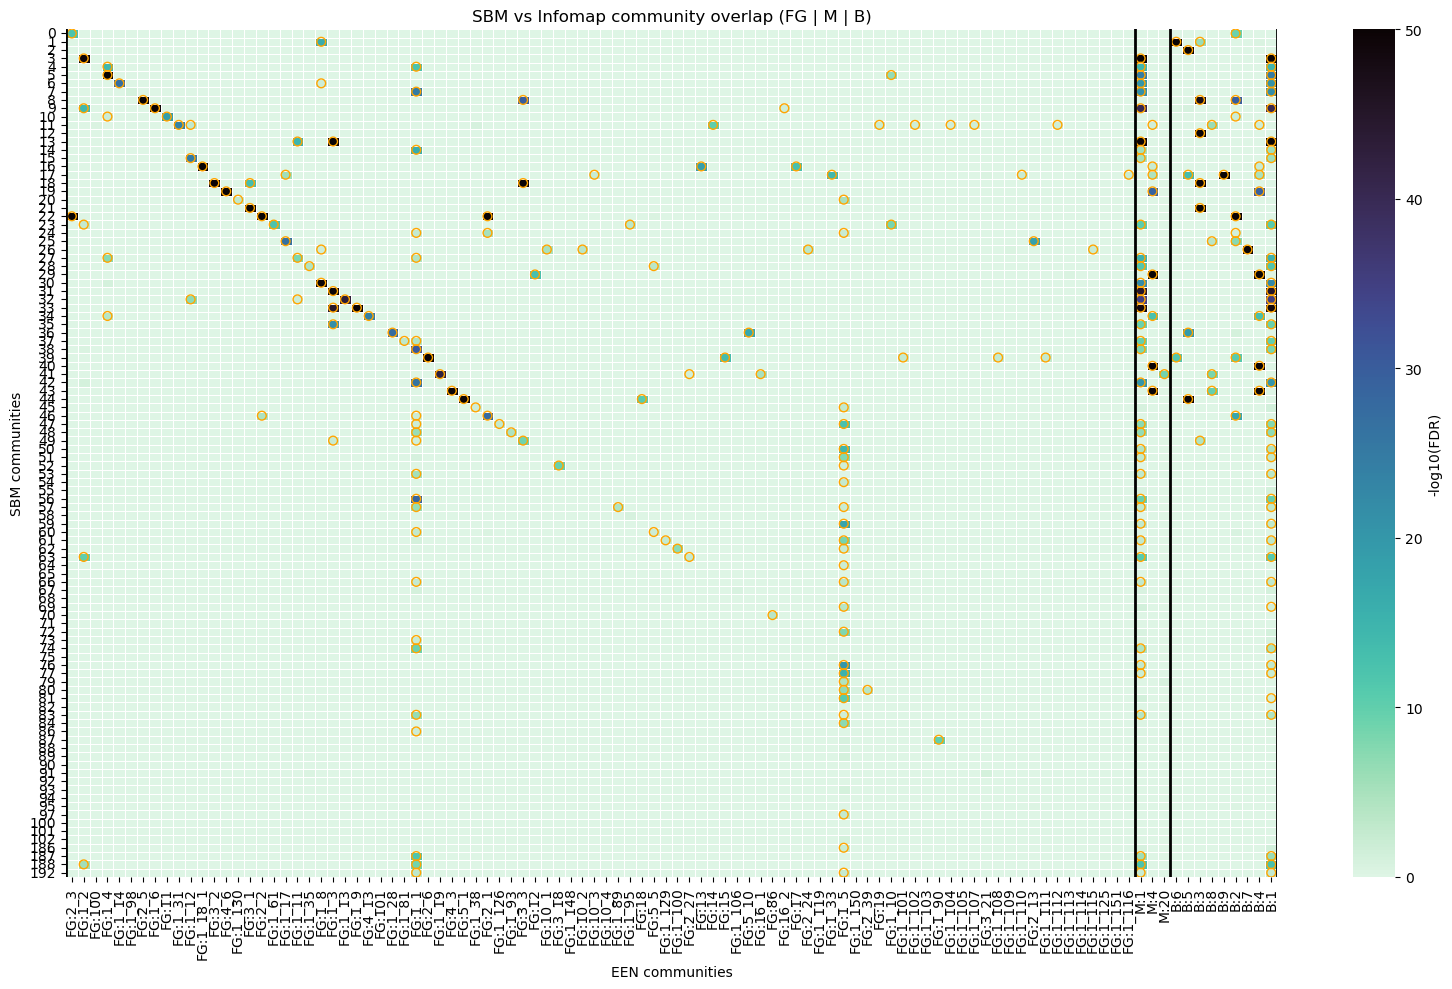

In [ ]:



plt.figure(figsize=(16,10))

ax = sns.heatmap(
    S,
    cmap="mako_r",
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"label": "-log10(FDR)"},
    xticklabels=True,
    yticklabels=True
)

# ---- Overlay significance circles (FDR < 0.05) ----
for i in range(S.shape[0]):        # SBM rows
    for j in range(S.shape[1]):    # FG|M|B columns
        if sig.iloc[i, j]:
            ax.scatter(
                j + 0.5, i + 0.5,
                s=40,
                facecolors='none',
                edgecolors='orange',
                linewidths=1
            )

# ---- Draw method separators ----
x = 0
for method in ["FG","M","B"]:
    n = sum(S.columns.str.startswith(method))
    plt.axvline(x, color="black", lw=2)
    x += n
plt.axvline(x, color="black", lw=2)


plt.title("SBM vs Infomap community overlap (FG | M | B)")
plt.xlabel("EEN communities")
plt.ylabel("SBM communities")

plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('output/SBM_exposures_Infomap_Heatmap.pdf', format='pdf', dpi=300, bbox_inches="tight")
plt.savefig('output/SBM_exposures_Infomap_Heatmap.png', format='png', dpi=300, bbox_inches="tight")
plt.show()

In [17]:

# -----------------------------
# Build export dataframe
# -----------------------------

export_records = []

for i, sbm in enumerate(S.index):
    for j, community in enumerate(S.columns):
        
        raw_fdr = M.loc[sbm, community]
        
        # Safe version used for log transform
        safe_fdr = raw_fdr if raw_fdr > 0 else 1e-300
        
        neglog_raw = -np.log10(safe_fdr)
        neglog_capped = S.loc[sbm, community]
        significance = raw_fdr < 0.05
        
        export_records.append({
            "SBM_community": sbm,
            "EEN_community": community,
            "Plot_row_index": i,
            "Plot_column_index": j,
            "Raw_FDR": raw_fdr,
            "Safe_FDR_for_log": safe_fdr,
            "-log10_FDR_raw": neglog_raw,
            "-log10_FDR_capped_at_50": neglog_capped,
            "Significant_FDR<0.05": significance
        })

df_heatmap_source = pd.DataFrame(export_records)

print("Total cells exported:", len(df_heatmap_source))

# -----------------------------
# Save to single Excel sheet
# -----------------------------

out_file = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(out_file,
                    engine="openpyxl",
                    mode="a",
                    if_sheet_exists="replace") as writer:

    df_heatmap_source.to_excel(
        writer,
        sheet_name="SF27C",
        index=False
    )

print("Heatmap source data saved successfully.")

Total cells exported: 10404
Heatmap source data saved successfully.


In [18]:

dicts = {
    "FG": bipartite_sbm_clustering_dict_genes_infomap_fg_fdr,
    "M":  bipartite_sbm_clustering_dict_genes_infomap_m_fdr,
    "B":  bipartite_sbm_clustering_dict_genes_infomap_b_fdr,
}

records = []

for method, D in dicts.items():
    for (sbm, uni), fdr in D.items():
        records.append((sbm, f"{method}:{uni}", float(fdr)))

df = pd.DataFrame(records, columns=["SBM", "Community", "FDR"])

M = df.pivot(index="SBM", columns="Community", values="FDR")
M = M.fillna(1.0)
M_safe = M.copy()
M_safe[M_safe <= 0] = 1e-300 

S = -np.log10(M_safe)
S[S > 50] = 50

from scipy.optimize import linear_sum_assignment

# Cost = negative significance → maximize diagonal signal
cost = -S.values

row_ind, col_ind = linear_sum_assignment(cost)

ordered_cols = S.columns[col_ind]
S = S[ordered_cols]
M = M[ordered_cols]

methods = S.columns.str.split(":").str[0]

method_order = ["FG", "M", "B"]
ordered_cols = (
    S.columns[methods == "FG"].tolist() +
    S.columns[methods == "M"].tolist() +
    S.columns[methods == "B"].tolist()
)

S = S[ordered_cols]
M = M[ordered_cols]
sig = (M < 0.05)

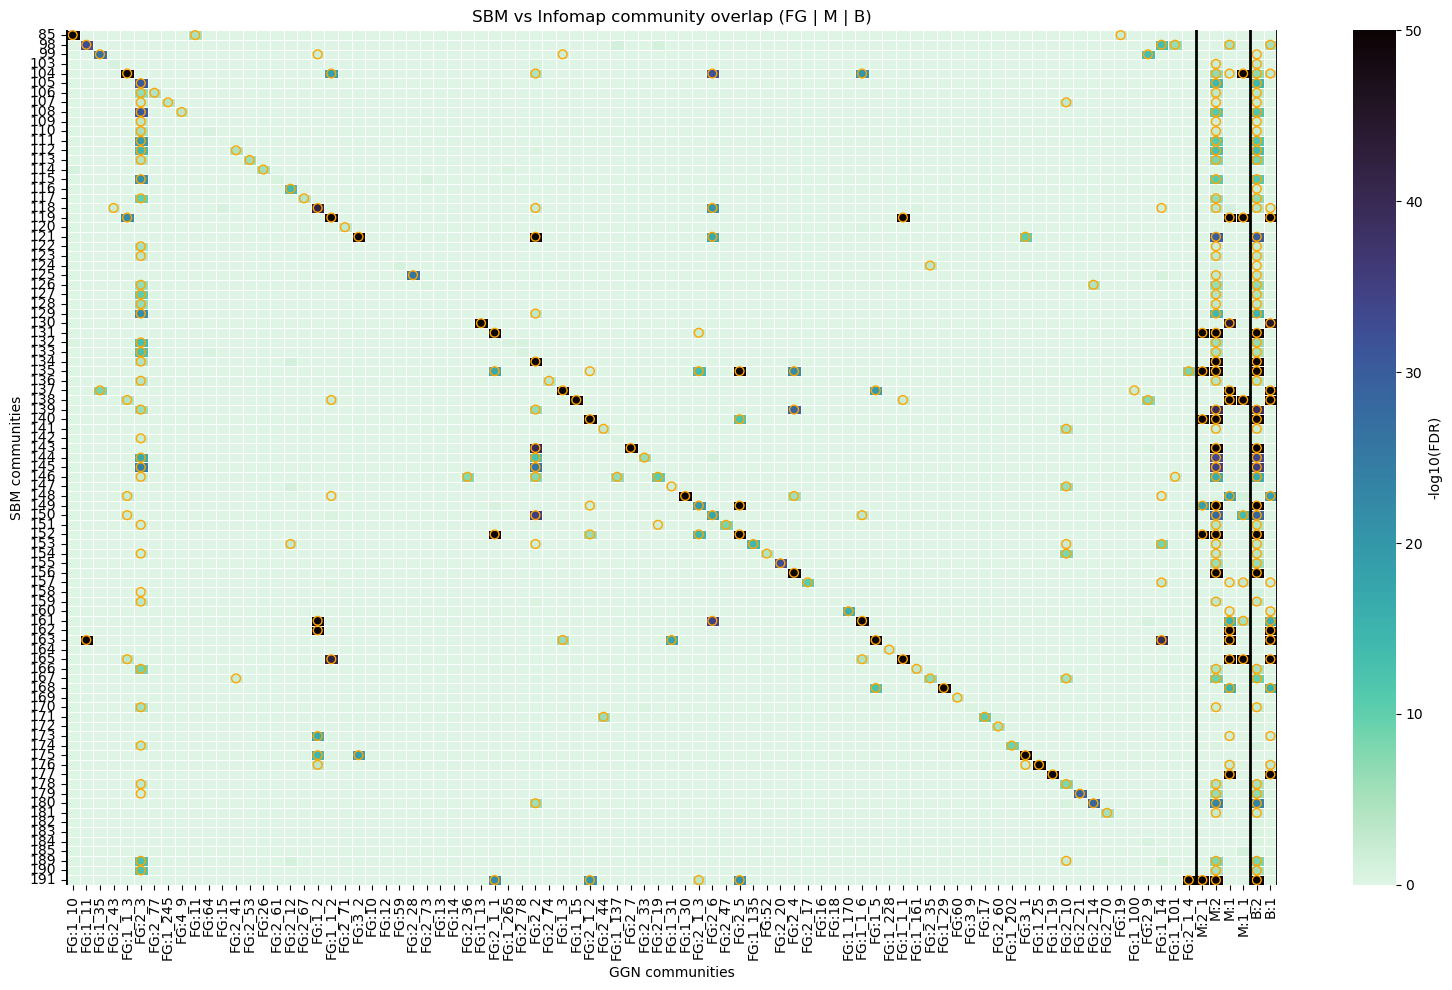

In [ ]:


plt.figure(figsize=(16,10))

ax = sns.heatmap(
    S,
    cmap="mako_r",
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"label": "-log10(FDR)"},
    xticklabels=True,
    yticklabels=True
)

# ---- Overlay significance circles (FDR < 0.05) ----
for i in range(S.shape[0]):        # SBM rows
    for j in range(S.shape[1]):    # FG|M|B columns
        if sig.iloc[i, j]:
            ax.scatter(
                j + 0.5, i + 0.5,
                s=40,
                facecolors='none',
                edgecolors='orange',
                linewidths=1
            )

# ---- Draw method separators ----
x = 0
for method in ["FG","M","B"]:
    n = sum(S.columns.str.startswith(method))
    plt.axvline(x, color="black", lw=2)
    x += n
plt.axvline(x, color="black", lw=2)


plt.title("SBM vs Infomap community overlap (FG | M | B)")
plt.xlabel("GGN communities")
plt.ylabel("SBM communities")

plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('output/Figures/SBM_genes_Infomap_Heatmap.pdf', format='pdf', dpi=300, bbox_inches="tight")
plt.savefig('output/Figures/SBM_genes_Infomap_Heatmap.png', format='png', dpi=300, bbox_inches="tight")
plt.show()

In [19]:

# -----------------------------
# Build export dataframe
# -----------------------------

export_records = []

for i, sbm in enumerate(S.index):
    for j, community in enumerate(S.columns):
        
        raw_fdr = M.loc[sbm, community]
        
        # Safe version used for log transform
        safe_fdr = raw_fdr if raw_fdr > 0 else 1e-300
        
        neglog_raw = -np.log10(safe_fdr)
        neglog_capped = S.loc[sbm, community]
        significance = raw_fdr < 0.05
        
        export_records.append({
            "SBM_community": sbm,
            "EEN_community": community,
            "Plot_row_index": i,
            "Plot_column_index": j,
            "Raw_FDR": raw_fdr,
            "Safe_FDR_for_log": safe_fdr,
            "-log10_FDR_raw": neglog_raw,
            "-log10_FDR_capped_at_50": neglog_capped,
            "Significant_FDR<0.05": significance
        })

df_heatmap_source = pd.DataFrame(export_records)

print("Total cells exported:", len(df_heatmap_source))

# -----------------------------
# Save to single Excel sheet
# -----------------------------

out_file = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(out_file,
                    engine="openpyxl",
                    mode="a",
                    if_sheet_exists="replace") as writer:

    df_heatmap_source.to_excel(
        writer,
        sheet_name="SF27D",
        index=False
    )

print("Heatmap source data saved successfully.")

Total cells exported: 7921
Heatmap source data saved successfully.


In [ ]:
#Let's run the Graphtool algorithm also for the unipartite network


# 1. Fast Loading with Pandas
# We skip nx.read_weighted_edgelist because it's slow for 1M+ lines.
# We assume the file is "Source Target Weight" separated by spaces or tabs.
print("Loading edgelist...")

# Adjust 'sep' if your file uses tabs ('\t') instead of spaces
df = pd.read_csv("backbone_gene_graph_significant_weighted.edgelist", 
                 sep=" ", # Common for .edgelist files
                 header=None, 
                 names=["source", "target", "weight"],
                 comment='#') # Skips comments if any

# 2. Map String IDs to Integers
# This is required because graph-tool nodes are indexed by integers 0...V-1
print("Mapping node IDs...")

# Get all unique nodes from both source and target columns
unique_nodes = pd.unique(df[['source', 'target']].values.ravel('K'))

# Create a dictionary to map string -> int
node_map = {name: i for i, name in enumerate(unique_nodes)}

# Apply the map to the dataframe to get integer columns
df['source_id'] = df['source'].map(node_map)
df['target_id'] = df['target'].map(node_map)

# 3. Bulk Build Graph
print("Building graph-tool object...")
g = gt.Graph(directed=False)

# Add all edges at once using numpy array (Super Fast)
# We strictly preserve the order so we can assign weights next
g.add_edge_list(df[['source_id', 'target_id']].values)

# 4. Add Weights (Efficiently)
# We create a new edge property map for weights
ep_weight = g.new_edge_property("double") 

# Direct Numpy assignment (works because edge order is preserved during bulk add)
ep_weight.a = df['weight'].values 
g.ep["weight"] = ep_weight

# Optional: Store original node names
vp_name = g.new_vertex_property("string")
# We iterate the map once to fill names (very fast for 50k nodes)
for name, idx in node_map.items():
    vp_name[g.vertex(idx)] = str(name)
g.vp["name"] = vp_name

print(f"Graph loaded: {g.num_vertices()} nodes, {g.num_edges()} edges.")

# 5. Optimized SBM Inference
print("Minimizing description length...")

# NOTE: This runs a structural SBM (grouping based on connectivity patterns).
# By default, this ignores the weights for the *grouping* logic, 
# which is usually desired for large biological networks. 
# (See "Advanced Note" below if weights are critical for grouping).
state = gt.minimize_blockmodel_dl(g)

print(f"Initial block count found: {state.get_nonempty_B()}")

# 6. MCMC Equilibration
print("Running MCMC equilibration...")

bs = [] # Store partitions here

def collect_partitions(s):
    bs.append(s.b.a.copy())

# We run the MCMC. 
# verbose=True helps you track progress (speed is usually ~0.1s per sweep)
gt.mcmc_equilibrate(state, 
                    force_niter=1000, 
                    mcmc_args=dict(niter=10, verbose=True),
                    callback=collect_partitions)

# 7. Consensus Mode
print("Calculating partition mode...")

pmode = gt.PartitionModeState(bs, converge=True)

# Get the best partition (mode)
# .get_max(g) extracts the consensus property map
# .a converts it to a numpy array
hard_partition = pmode.get_max(g).a


# Create a DataFrame for easy saving
results = pd.DataFrame({
    "Node": [g.vp["name"][v] for v in g.vertices()],
    "Block": hard_partition
})


Loading edgelist...
Mapping node IDs...
Building graph-tool object...
Graph loaded: 22338 nodes, 762862 edges.
Minimizing description length...
Initial block count found: 256
Running MCMC equilibration...
split proposal: 16643 4410 64 29 206.283 -8.48782 -11.8379 -202.933
merge proposal: 3959 6515 72 204 1386.97 -8.69744 -7.75394 -1387.92
merge proposal: 3844 10365 14 181 3134.85 -6.23444 -9.68578 -3131.4
merge proposal: 18398 15673 20 39 4855.9 -6.23441 -10.285 -4851.85
merge 9683 11045 446 266 4506.83 -3.38054  -1.92893 
split 11045 9683 267 445 -4504.91 -4.01205 -3.39263
mergesplit proposal: 9683 11045 1.91993 -5.32156 -7.39259 0.151099
split proposal: 19507 531 2 5 328.931 -10.6885 -6.23832 -333.381
merge 6523 8558 49 80 2216.77 -4.42269  -0.705006 
split 8558 6523 80 49 -2216.77 -0.705006 -4.42269
mergesplit proposal: 6523 8558 -3.72893e-11 -5.12769 -5.12769 3.72902e-11
split proposal: 22178 3447 6 30 384.256 -9.4103 -6.23833 -387.428
merge 9683 18265 447 123 3971.43 -6.27188  -99

In [44]:


SBM_GGN_communities_dict = {}

for com in set(hard_partition):
    node_list = []
    for i,part in enumerate(hard_partition):   
        if com==part:
            node_list.append(results['Node'][i])
    SBM_GGN_communities_dict[com] = node_list

In [46]:
print(len(SBM_GGN_communities_dict))

263


In [ ]:
with open('output/SBM_GGN_communities_dict.pickle', 'wb') as handle:
    pk.dump(SBM_GGN_communities_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

In [20]:
with open('output/SBM_GGN_communities_dict.pickle', 'rb') as handle:
    SBM_GGN_communities_dict = pk.load(handle)

In [48]:
#Let's run the Graphtool algorithm also for the unipartite network


# 1. Fast Loading with Pandas
# We skip nx.read_weighted_edgelist because it's slow for 1M+ lines.
# We assume the file is "Source Target Weight" separated by spaces or tabs.
print("Loading edgelist...")

# Adjust 'sep' if your file uses tabs ('\t') instead of spaces
df = pd.read_csv("backbone_exp_graph_significant_weighted.edgelist", 
                 sep=" ", # Common for .edgelist files
                 header=None, 
                 names=["source", "target", "weight"],
                 comment='#') # Skips comments if any

# 2. Map String IDs to Integers
# This is required because graph-tool nodes are indexed by integers 0...V-1
print("Mapping node IDs...")

# Get all unique nodes from both source and target columns
unique_nodes = pd.unique(df[['source', 'target']].values.ravel('K'))

# Create a dictionary to map string -> int
node_map = {name: i for i, name in enumerate(unique_nodes)}

# Apply the map to the dataframe to get integer columns
df['source_id'] = df['source'].map(node_map)
df['target_id'] = df['target'].map(node_map)

# 3. Bulk Build Graph
print("Building graph-tool object...")
g = gt.Graph(directed=False)

# Add all edges at once using numpy array (Super Fast)
# We strictly preserve the order so we can assign weights next
g.add_edge_list(df[['source_id', 'target_id']].values)

# 4. Add Weights (Efficiently)
# We create a new edge property map for weights
ep_weight = g.new_edge_property("double") 

# Direct Numpy assignment (works because edge order is preserved during bulk add)
ep_weight.a = df['weight'].values 
g.ep["weight"] = ep_weight

# Optional: Store original node names
vp_name = g.new_vertex_property("string")
# We iterate the map once to fill names (very fast for 50k nodes)
for name, idx in node_map.items():
    vp_name[g.vertex(idx)] = str(name)
g.vp["name"] = vp_name

print(f"Graph loaded: {g.num_vertices()} nodes, {g.num_edges()} edges.")

# 5. Optimized SBM Inference
print("Minimizing description length...")

# NOTE: This runs a structural SBM (grouping based on connectivity patterns).
# By default, this ignores the weights for the *grouping* logic, 
# which is usually desired for large biological networks. 
# (See "Advanced Note" below if weights are critical for grouping).
state = gt.minimize_blockmodel_dl(g)

print(f"Initial block count found: {state.get_nonempty_B()}")

# 6. MCMC Equilibration
print("Running MCMC equilibration...")

bs = [] # Store partitions here

def collect_partitions(s):
    bs.append(s.b.a.copy())

# We run the MCMC. 
# verbose=True helps you track progress (speed is usually ~0.1s per sweep)
gt.mcmc_equilibrate(state, 
                    force_niter=1000, 
                    mcmc_args=dict(niter=10),
                    callback=collect_partitions)

# 7. Consensus Mode
print("Calculating partition mode...")

pmode = gt.PartitionModeState(bs, converge=True)

# Get the best partition (mode)
# .get_max(g) extracts the consensus property map
# .a converts it to a numpy array
hard_partition = pmode.get_max(g).a


# Create a DataFrame for easy saving
results = pd.DataFrame({
    "Node": [g.vp["name"][v] for v in g.vertices()],
    "Block": hard_partition
})

Loading edgelist...
Mapping node IDs...
Building graph-tool object...
Graph loaded: 9764 nodes, 736470 edges.
Minimizing description length...
Initial block count found: 215
Running MCMC equilibration...
Calculating partition mode...


In [49]:
SBM_EEN_communities_dict = {}

for com in set(hard_partition):
    node_list = []
    for i,part in enumerate(hard_partition):   
        if com==part:
            node_list.append(results['Node'][i])
    SBM_EEN_communities_dict[com] = node_list

print(len(SBM_EEN_communities_dict))

249


In [ ]:
with open('output/SBM_EEN_communities_dict.pickle', 'wb') as handle:
    pk.dump(SBM_EEN_communities_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

In [21]:
with open('output/SBM_EEN_communities_dict.pickle', 'rb') as handle:
    SBM_EEN_communities_dict = pk.load(handle)

In [22]:
bipartite_sbm_clustering_dict_exposures_sbm_pval = {}
bipartite_sbm_clustering_dict_exposures_sbm_fdr = {}
sig_overlapping_exposures_sbm_communities = []

bipartite_sbm_clustering_dict_genes_sbm_pval = {}
bipartite_sbm_clustering_dict_genes_sbm_fdr = {}
sig_overlapping_genes_sbm_communities = []

for com_partition,explist in bipartite_sbm_clustering_dict_exposures.items():
    for com_sbm, sbm_explist in SBM_EEN_communities_dict.items():
        overlap_pval = overlap_set(set(explist), set(sbm_explist), len(chem_map))
        if str(overlap_pval)!='nan':
            bipartite_sbm_clustering_dict_exposures_sbm_pval[(com_partition,com_sbm)] = float(overlap_pval)
pvals = list(bipartite_sbm_clustering_dict_exposures_sbm_pval.values())
fdrs = fdr_adjustment(pvals,0.05)
for i,key in enumerate(bipartite_sbm_clustering_dict_exposures_sbm_pval.keys()):
    bipartite_sbm_clustering_dict_exposures_sbm_fdr[key] = fdrs[i]

for com_partition in bipartite_sbm_clustering_dict_exposures.keys():
    for com_pair,fdr in bipartite_sbm_clustering_dict_exposures_sbm_fdr.items():
        if com_partition==com_pair[0]:
            if fdr<=0.05:
                sig_overlapping_exposures_sbm_communities.append(com_partition)

for com_partition,genelist in bipartite_sbm_clustering_dict_genes.items():
    for com_sbm, sbm_genelist in SBM_GGN_communities_dict.items():
        overlap_pval = overlap_set(set(genelist), set(sbm_genelist), len(gene_map))
        if str(overlap_pval)!='nan':
            bipartite_sbm_clustering_dict_genes_sbm_pval[(com_partition,com_sbm)] = float(overlap_pval)
pvals = list(bipartite_sbm_clustering_dict_genes_sbm_pval.values())
fdrs = fdr_adjustment(pvals,0.05)
for i,key in enumerate(bipartite_sbm_clustering_dict_genes_sbm_pval.keys()):
    bipartite_sbm_clustering_dict_genes_sbm_fdr[key] = fdrs[i]

for com_partition in bipartite_sbm_clustering_dict_genes.keys():
    for com_pair,fdr in bipartite_sbm_clustering_dict_genes_sbm_fdr.items():
        if com_partition==com_pair[0]:
            if fdr<=0.05:
                sig_overlapping_genes_sbm_communities.append(com_partition)

print(len(set(sig_overlapping_exposures_sbm_communities)))
print(len(set(sig_overlapping_genes_sbm_communities)))

88
80


In [23]:
records = []
for (sbm, uni), fdr in bipartite_sbm_clustering_dict_exposures_sbm_fdr.items():
    records.append((sbm, str(uni), float(fdr)))

df = pd.DataFrame(records, columns=["SBM", "Community", "FDR"])

M = df.pivot(index="SBM", columns="Community", values="FDR")
M = M.fillna(1.0)

M_safe = M.copy()
M_safe[M_safe <= 0] = 1e-300   # avoid inf

S = -np.log10(M_safe)
S[S > 50] = 50                # cap extreme values

cost = -S.values
row_ind, col_ind = linear_sum_assignment(cost)

ordered_cols = S.columns[col_ind]
S = S[ordered_cols]
M = M[ordered_cols]

sig = (M < 0.05)

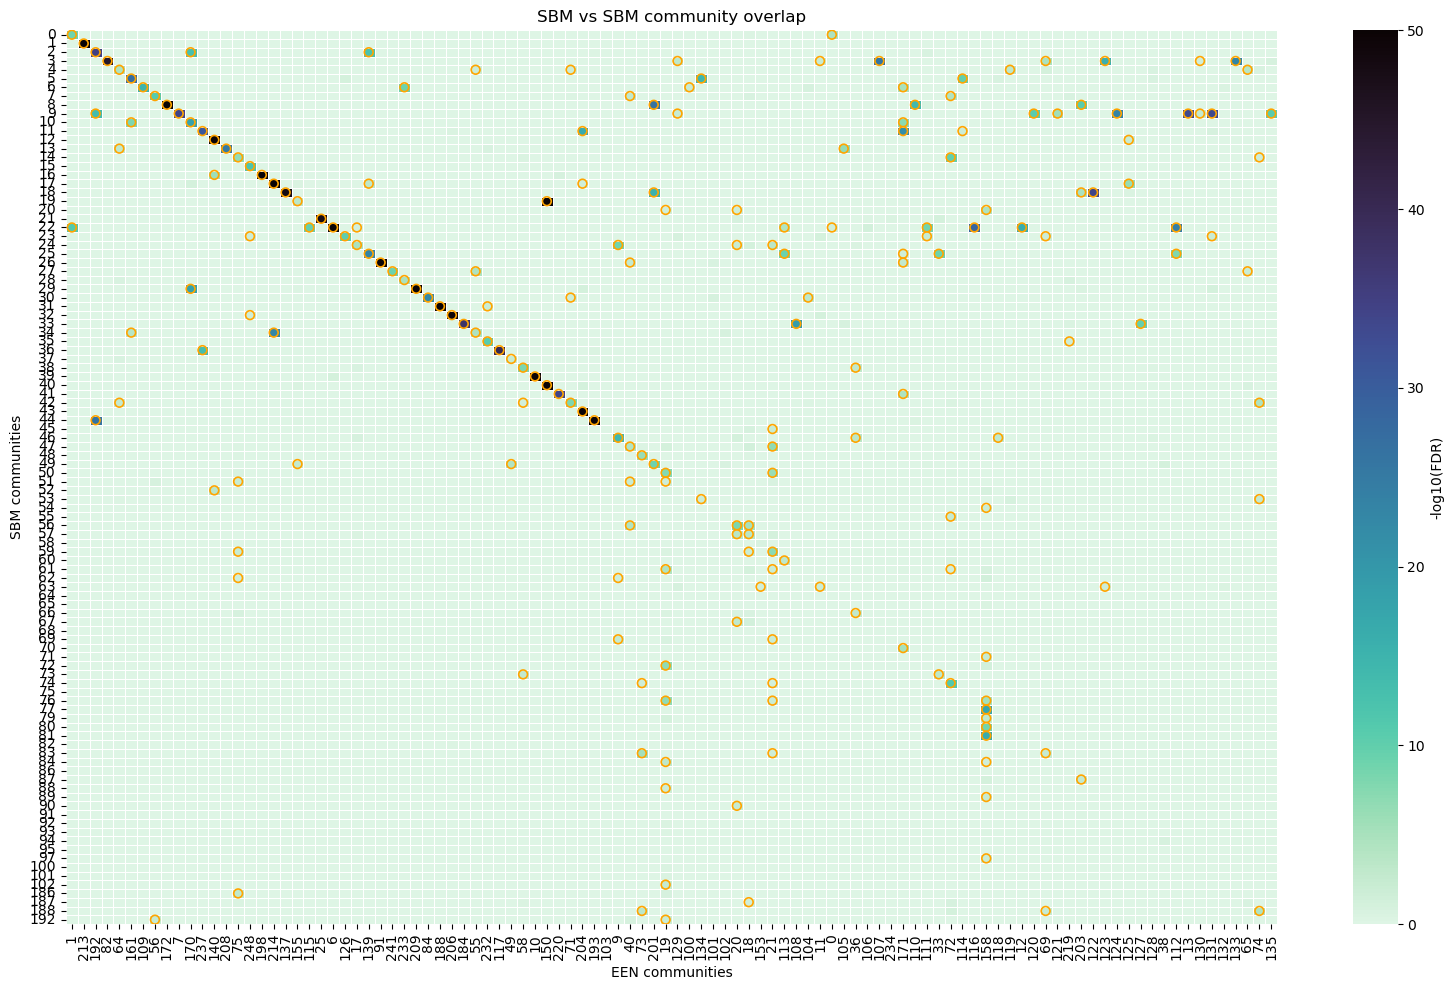

In [ ]:


plt.figure(figsize=(16,10))

ax = sns.heatmap(
    S,
    cmap="mako_r",
    linewidths=0.4,
    linecolor="white",
    cbar_kws={"label": "-log10(FDR)"},
    xticklabels=True,
    yticklabels=True
)


for i in range(S.shape[0]):
    for j in range(S.shape[1]):
        if sig.iloc[i, j]:
            ax.scatter(
                j + 0.5, i + 0.5,
                s=40,
                facecolors='none',
                edgecolors='orange',
                linewidths=1.2
            )


plt.title("SBM vs SBM community overlap")
plt.xlabel("EEN communities")
plt.ylabel("SBM communities")

plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("output/SBM_exposures_SBM_Heatmap.pdf",
            format="pdf", dpi=300, bbox_inches="tight")
plt.savefig("output/SBM_exposures_SBM_Heatmap.png",
            format="png", dpi=300, bbox_inches="tight")
plt.show()

In [24]:

# -----------------------------
# Build export dataframe
# -----------------------------

export_records = []

for i, sbm in enumerate(S.index):
    for j, community in enumerate(S.columns):
        
        raw_fdr = M.loc[sbm, community]
        
        # Safe version used for log transform
        safe_fdr = raw_fdr if raw_fdr > 0 else 1e-300
        
        neglog_raw = -np.log10(safe_fdr)
        neglog_capped = S.loc[sbm, community]
        significance = raw_fdr < 0.05
        
        export_records.append({
            "SBM_community": sbm,
            "EEN_community": community,
            "Plot_row_index": i,
            "Plot_column_index": j,
            "Raw_FDR": raw_fdr,
            "Safe_FDR_for_log": safe_fdr,
            "-log10_FDR_raw": neglog_raw,
            "-log10_FDR_capped_at_50": neglog_capped,
            "Significant_FDR<0.05": significance
        })

df_heatmap_source = pd.DataFrame(export_records)

print("Total cells exported:", len(df_heatmap_source))

# -----------------------------
# Save to single Excel sheet
# -----------------------------

out_file = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(out_file,
                    engine="openpyxl",
                    mode="a",
                    if_sheet_exists="replace") as writer:

    df_heatmap_source.to_excel(
        writer,
        sheet_name="SF27E",
        index=False
    )

print("Heatmap source data saved successfully.")

Total cells exported: 10404
Heatmap source data saved successfully.


In [25]:
records = []
for (sbm, uni), fdr in bipartite_sbm_clustering_dict_genes_sbm_fdr.items():
    records.append((sbm, str(uni), float(fdr)))

df = pd.DataFrame(records, columns=["SBM", "Community", "FDR"])

M = df.pivot(index="SBM", columns="Community", values="FDR")
M = M.fillna(1.0)

M_safe = M.copy()
M_safe[M_safe <= 0] = 1e-300   # avoid inf

S = -np.log10(M_safe)
S[S > 50] = 50                # cap extreme values

cost = -S.values
row_ind, col_ind = linear_sum_assignment(cost)

ordered_cols = S.columns[col_ind]
S = S[ordered_cols]
M = M[ordered_cols]

sig = (M < 0.05)

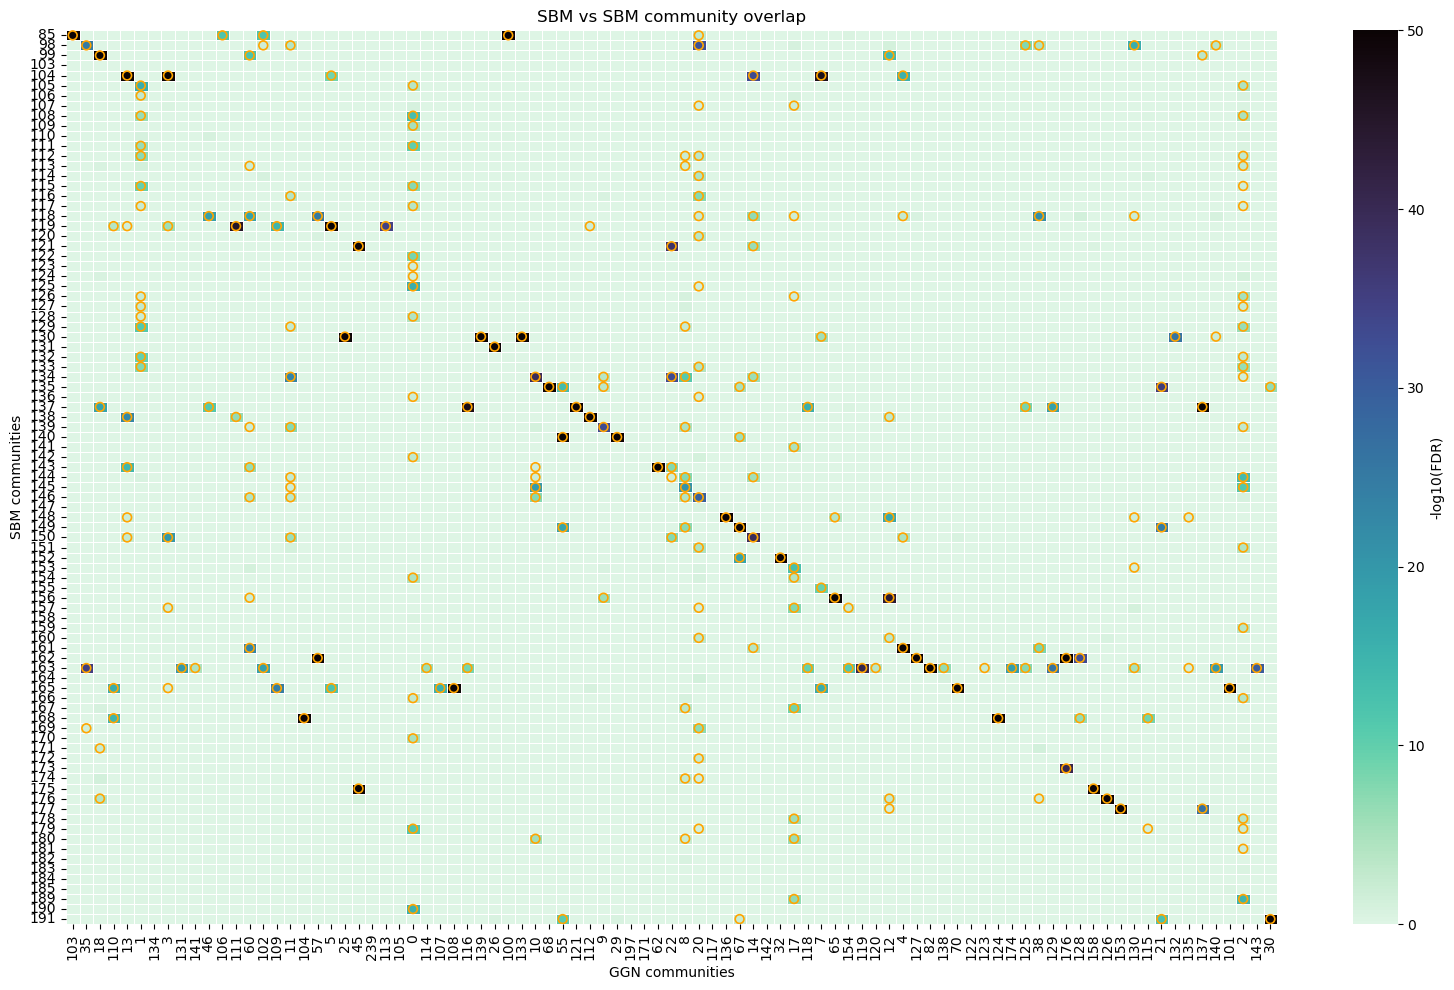

In [ ]:


plt.figure(figsize=(16,10))

ax = sns.heatmap(
    S,
    cmap="mako_r",
    linewidths=0.4,
    linecolor="white",
    cbar_kws={"label": "-log10(FDR)"},
    xticklabels=True,
    yticklabels=True
)


for i in range(S.shape[0]):
    for j in range(S.shape[1]):
        if sig.iloc[i, j]:
            ax.scatter(
                j + 0.5, i + 0.5,
                s=40,
                facecolors='none',
                edgecolors='orange',
                linewidths=1.2
            )


plt.title("SBM vs SBM community overlap")
plt.xlabel("GGN communities")
plt.ylabel("SBM communities")

plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("output/SBM_genes_SBM_Heatmap.pdf",
            format="pdf", dpi=300, bbox_inches="tight")
plt.savefig("output/SBM_genes_SBM_Heatmap.png",
            format="png", dpi=300, bbox_inches="tight")
plt.show()

In [26]:

# -----------------------------
# Build export dataframe
# -----------------------------

export_records = []

for i, sbm in enumerate(S.index):
    for j, community in enumerate(S.columns):
        
        raw_fdr = M.loc[sbm, community]
        
        # Safe version used for log transform
        safe_fdr = raw_fdr if raw_fdr > 0 else 1e-300
        
        neglog_raw = -np.log10(safe_fdr)
        neglog_capped = S.loc[sbm, community]
        significance = raw_fdr < 0.05
        
        export_records.append({
            "SBM_community": sbm,
            "EEN_community": community,
            "Plot_row_index": i,
            "Plot_column_index": j,
            "Raw_FDR": raw_fdr,
            "Safe_FDR_for_log": safe_fdr,
            "-log10_FDR_raw": neglog_raw,
            "-log10_FDR_capped_at_50": neglog_capped,
            "Significant_FDR<0.05": significance
        })

df_heatmap_source = pd.DataFrame(export_records)

print("Total cells exported:", len(df_heatmap_source))

# -----------------------------
# Save to single Excel sheet
# -----------------------------

out_file = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(out_file,
                    engine="openpyxl",
                    mode="a",
                    if_sheet_exists="replace") as writer:

    df_heatmap_source.to_excel(
        writer,
        sheet_name="SF27F",
        index=False
    )

print("Heatmap source data saved successfully.")

Total cells exported: 7921
Heatmap source data saved successfully.


In [54]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html#sklearn.metrics.adjusted_mutual_info_score

# restrict to nodes present in both networks
nodes = set().union(*bipartite_sbm_clustering_dict_genes.values()) & set().union(*SBM_GGN_communities_dict.values())

# build label vectors
label_A = []
label_B = []
for n in nodes:
    for k, v in bipartite_sbm_clustering_dict_genes.items():
        if n in v:
            label_A.append(k)
            break
    for k, v in SBM_GGN_communities_dict.items():
        if n in v:
            label_B.append(k)
            break

# compare partitions
ari = adjusted_rand_score(label_A, label_B)
ami = adjusted_mutual_info_score(label_A, label_B)

print("ARI:", ari)
print("AMI:", ami)

ARI: 0.09737988038508796
AMI: 0.439416707862094


In [55]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html#sklearn.metrics.adjusted_mutual_info_score

# restrict to nodes present in both networks
nodes = set().union(*bipartite_sbm_clustering_dict_exposures.values()) & set().union(*SBM_EEN_communities_dict.values())

# build label vectors
label_A = []
label_B = []
for n in nodes:
    for k, v in bipartite_sbm_clustering_dict_exposures.items():
        if n in v:
            label_A.append(k)
            break
    for k, v in SBM_EEN_communities_dict.items():
        if n in v:
            label_B.append(k)
            break

# compare partitions
ari = adjusted_rand_score(label_A, label_B)
ami = adjusted_mutual_info_score(label_A, label_B)

print("ARI:", ari)
print("AMI:", ami)

ARI: 0.09880298976186058
AMI: 0.3551968473938115


In [56]:
import numpy as np
from scipy.optimize import linear_sum_assignment

def jaccard(a, b):
    return len(a & b) / len(a | b) if a | b else 0

# community lists
A_keys, B_keys = list(bipartite_sbm_clustering_dict_exposures.keys()), list(SBM_EEN_communities_dict.keys())
sim_matrix = np.zeros((len(A_keys), len(B_keys)))

for i, kA in enumerate(A_keys):
    for j, kB in enumerate(B_keys):
        sim_matrix[i, j] = jaccard(set(bipartite_sbm_clustering_dict_exposures[kA]), set(SBM_EEN_communities_dict[kB]))

# maximize similarity → minimize negative
row_ind, col_ind = linear_sum_assignment(-sim_matrix)

matches = [(A_keys[i], B_keys[j], sim_matrix[i, j]) 
           for i, j in zip(row_ind, col_ind)]

sbm_exposures_com_ji_list = [i[2] for i in matches]

# community lists
A_keys, B_keys = list(bipartite_sbm_clustering_dict_genes.keys()), list(SBM_GGN_communities_dict.keys())
sim_matrix = np.zeros((len(A_keys), len(B_keys)))

for i, kA in enumerate(A_keys):
    for j, kB in enumerate(B_keys):
        sim_matrix[i, j] = jaccard(set(bipartite_sbm_clustering_dict_genes[kA]), set(SBM_GGN_communities_dict[kB]))

# maximize similarity → minimize negative
row_ind, col_ind = linear_sum_assignment(-sim_matrix)

matches = [(A_keys[i], B_keys[j], sim_matrix[i, j]) 
           for i, j in zip(row_ind, col_ind)]

sbm_genes_com_ji_list = [i[2] for i in matches]



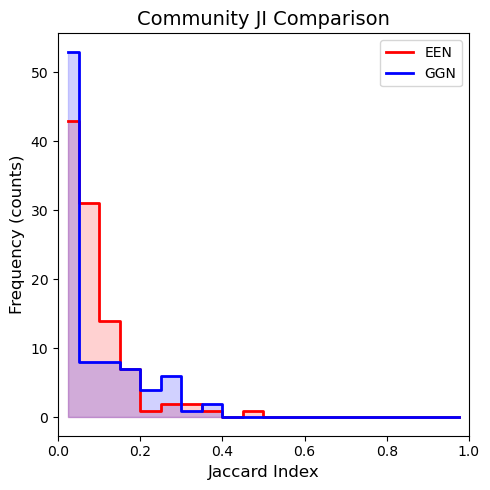

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Put your lists here
a = np.array(sbm_exposures_com_ji_list, dtype=float)
b = np.array(sbm_genes_com_ji_list, dtype=float)

# Clean (remove NaN and keep values in [0,1])
def clean(arr):
    arr = arr[~np.isnan(arr)]
    return arr[(arr >= 0) & (arr <= 1)]

a = clean(a)
b = clean(b)

# Common bins across 0..1
n_bins = 20
bins = np.linspace(0.0, 1.0, n_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Compute counts per bin
counts_a, _ = np.histogram(a, bins=bins)
counts_b, _ = np.histogram(b, bins=bins)

# Plot as step lines + light fill — clean and easy to compare
plt.figure(figsize=(5, 5))

colors = {"EEN": "red", "GGN": "blue"}

plt.step(bin_centers, counts_a, where='mid', label="EEN", color=colors["EEN"], linewidth=2)
plt.fill_between(bin_centers, counts_a, step='mid', alpha=0.18, color=colors["EEN"])

plt.step(bin_centers, counts_b, where='mid', label="GGN", color=colors["GGN"], linewidth=2)
plt.fill_between(bin_centers, counts_b, step='mid', alpha=0.18, color=colors["GGN"])

plt.xlabel("Jaccard Index", fontsize=12)
plt.ylabel("Frequency (counts)", fontsize=12)
plt.title("Community JI Comparison", fontsize=14)
plt.xlim(0, 1)
plt.legend()
plt.grid(False)   # no grid as requested
plt.tight_layout()

# save + show
#plt.savefig("output/Figures/SBM_Comparison.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [63]:
bipartite_sbm_clustering_dict_exposures_rev = {}
for chem in chem_map.keys():
    for com,explist in bipartite_sbm_clustering_dict_exposures.items():
        if chem in explist:
            bipartite_sbm_clustering_dict_exposures_rev[chem] = com

SBM_EEN_communities_dict_rev = {}
for chem in chem_map.keys():
    for com,explist in SBM_EEN_communities_dict.items():
        if chem in explist:
            SBM_EEN_communities_dict_rev[chem] = com


In [76]:
nodes = list(SBM_EEN_communities_dict_rev.keys())

labels_A = [SBM_EEN_communities_dict_rev[n] for n in nodes]
labels_B = [bipartite_sbm_clustering_dict_exposures_rev[n] for n in nodes]

A_coms = sorted(list(set(labels_A)))
B_coms = sorted(list(set(labels_B)))

overlap = pd.DataFrame(0, index=A_coms, columns=B_coms)

for n in nodes:
    overlap.loc[SBM_EEN_communities_dict_rev[n], bipartite_sbm_clustering_dict_exposures_rev[n]] += 1

# Normalize by A community size
overlap_frac = overlap.div(overlap.sum(axis=1), axis=0)

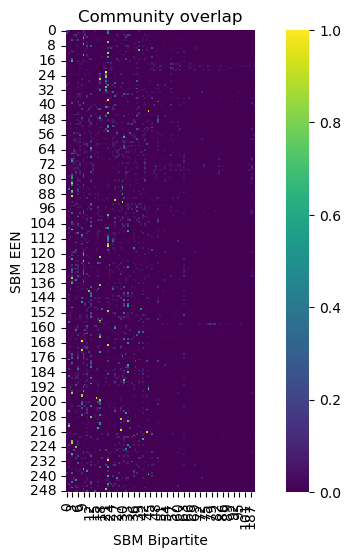

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(overlap_frac, cmap="viridis", square=True)
plt.xlabel("SBM Bipartite")
plt.ylabel("SBM EEN")
plt.title("Community overlap")
plt.show()

In [78]:
mapping = overlap_frac.idxmax(axis=1)
scores = overlap_frac.max(axis=1)

community_matching = pd.DataFrame({
    "A → B": mapping,
    "Overlap": scores
})

print(community_matching)

     A → B   Overlap
0       22  0.333333
1       22  0.527778
2       33  0.208333
3        9  0.479167
4        9  0.714286
..     ...       ...
244     22  0.555556
245     22  0.136364
246      3  0.454545
247     21  0.800000
248     15  0.264706

[249 rows x 2 columns]


In [79]:
len(community_matching[community_matching['Overlap']>0.5])

93

In [ ]:
#We want to create a heatmap where each cell is a FDR and elements (communties) are ordered so that the most significant
#FDR follows the element of the diagonal.

In [27]:
louvain_fine_grained_overlapping_communities_een = 85
louvain_fine_grained_overlapping_communities_ggn = 82

louvain_middle_overlapping_communities_een = 80
louvain_middle_overlapping_communities_ggn = 76

louvain_broad_overlapping_communities_een = 28
louvain_broad_overlapping_communities_ggn = 0

infomap_fine_grained_overlapping_communities_een = 83
infomap_fine_grained_overlapping_communities_ggn = 84

infomap_middle_overlapping_communities_een = 63
infomap_middle_overlapping_communities_ggn = 72

infomap_broad_overlapping_communities_een = 66
infomap_broad_overlapping_communities_ggn = 73

sbm_fine_grained_overlapping_communities_een = 88
sbm_fine_grained_overlapping_communities_ggn = 80



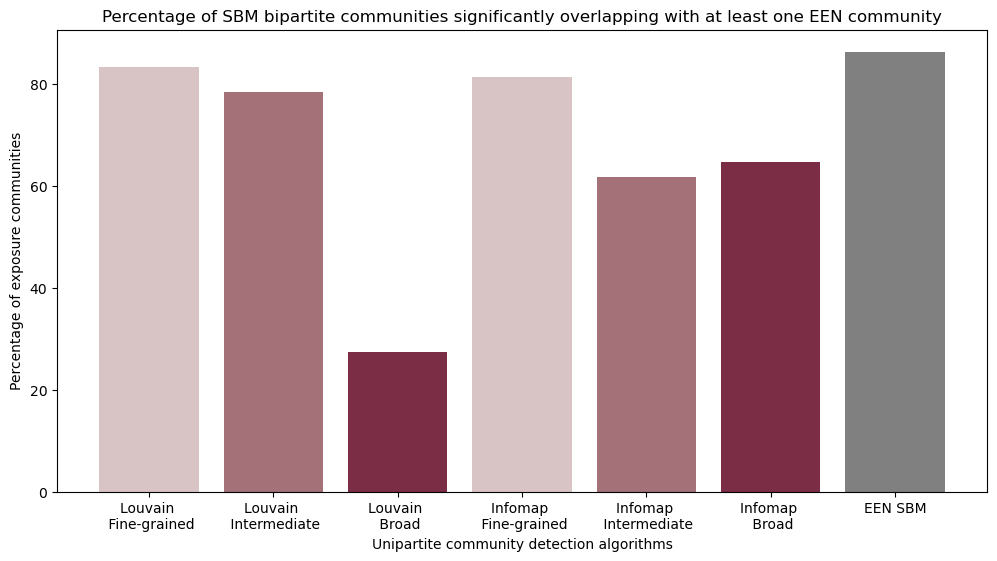

In [193]:

data = [100*el/len(bipartite_sbm_clustering_dict_exposures) for el in [louvain_fine_grained_overlapping_communities_een, louvain_middle_overlapping_communities_een, louvain_broad_overlapping_communities_een,
        infomap_fine_grained_overlapping_communities_een, infomap_middle_overlapping_communities_een, infomap_broad_overlapping_communities_een,
        sbm_fine_grained_overlapping_communities_een]]


# Labels for the x-axis
labels = ['Louvain \n Fine-grained', 'Louvain \n Intermediate', 'Louvain \n Broad',
          'Infomap \n Fine-grained', 'Infomap \n Intermediate', 'Infomap \n Broad',
          'EEN SBM'
         ]
color_list = ['#D8C4C5','#A47179','#7A2D45','#D8C4C5','#A47179','#7A2D45','grey']
fig, ax = plt.subplots(figsize=(12, 6))

# Create the rest of the bars
ax.bar(labels, data, color=color_list)

# Add titles and labels
plt.xlabel('Unipartite community detection algorithms')
plt.ylabel('Percentage of exposure communities')
plt.title('Percentage of SBM bipartite communities significantly overlapping with at least one EEN community')

plt.savefig('output/SBM_exposures.pdf',format='pdf',dpi=300, bbox_inches = "tight")
# Display the plot
plt.show()

In [28]:

data = [100*el/len(bipartite_sbm_clustering_dict_exposures) for el in [louvain_fine_grained_overlapping_communities_een, louvain_middle_overlapping_communities_een, louvain_broad_overlapping_communities_een,
        infomap_fine_grained_overlapping_communities_een, infomap_middle_overlapping_communities_een, infomap_broad_overlapping_communities_een,
        sbm_fine_grained_overlapping_communities_een]]


# Labels for the x-axis
labels = ['Louvain \n Fine-grained', 'Louvain \n Intermediate', 'Louvain \n Broad',
          'Infomap \n Fine-grained', 'Infomap \n Intermediate', 'Infomap \n Broad',
          'EEN SBM'
         ]

rows = []


# Remaining single bars
for label, value in zip(labels[1:], data[1:]):
    rows.append({
        "Method": label,
        "Segment": "single",
        "Value": value,
        "Color": "black"
    })

source_df = pd.DataFrame(rows)

excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="new"
    ) as writer:

    source_df.to_excel(
        writer,
        sheet_name="SF28A",
        index=False
    )

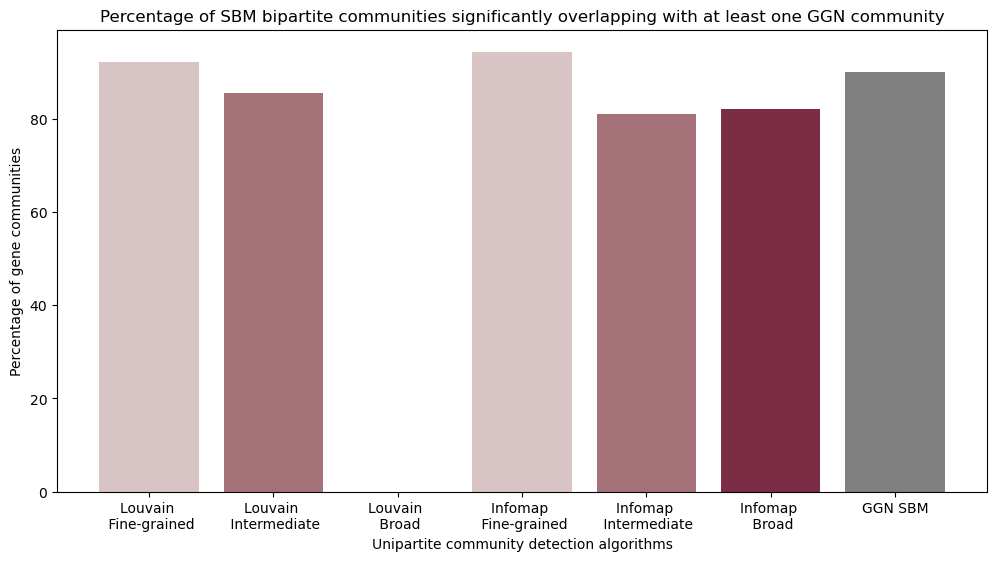

In [194]:

data = [100*el/len(bipartite_sbm_clustering_dict_genes) for el in [louvain_fine_grained_overlapping_communities_ggn, louvain_middle_overlapping_communities_ggn, louvain_broad_overlapping_communities_ggn,
        infomap_fine_grained_overlapping_communities_ggn, infomap_middle_overlapping_communities_ggn, infomap_broad_overlapping_communities_ggn,
        sbm_fine_grained_overlapping_communities_ggn]]


# Labels for the x-axis
labels = ['Louvain \n Fine-grained', 'Louvain \n Intermediate', 'Louvain \n Broad',
          'Infomap \n Fine-grained', 'Infomap \n Intermediate', 'Infomap \n Broad',
          'GGN SBM'
         ]
color_list = ['#D8C4C5','#A47179','#7A2D45','#D8C4C5','#A47179','#7A2D45','grey']
fig, ax = plt.subplots(figsize=(12, 6))

# Create the rest of the bars
ax.bar(labels, data, color=color_list)

# Add titles and labels
plt.xlabel('Unipartite community detection algorithms')
plt.ylabel('Percentage of gene communities')
plt.title('Percentage of SBM bipartite communities significantly overlapping with at least one GGN community')

plt.savefig('output/SBM_genes.pdf',format='pdf',dpi=300, bbox_inches = "tight")
# Display the plot
plt.show()

In [29]:
data = [100*el/len(bipartite_sbm_clustering_dict_genes) for el in [louvain_fine_grained_overlapping_communities_ggn, louvain_middle_overlapping_communities_ggn, louvain_broad_overlapping_communities_ggn,
        infomap_fine_grained_overlapping_communities_ggn, infomap_middle_overlapping_communities_ggn, infomap_broad_overlapping_communities_ggn,
        sbm_fine_grained_overlapping_communities_ggn]]


# Labels for the x-axis
labels = ['Louvain \n Fine-grained', 'Louvain \n Intermediate', 'Louvain \n Broad',
          'Infomap \n Fine-grained', 'Infomap \n Intermediate', 'Infomap \n Broad',
          'GGN SBM'
         ]

rows = []


# Remaining single bars
for label, value in zip(labels[1:], data[1:]):
    rows.append({
        "Method": label,
        "Segment": "single",
        "Value": value,
        "Color": "black"
    })

source_df = pd.DataFrame(rows)

excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="new"
    ) as writer:

    source_df.to_excel(
        writer,
        sheet_name="SF28B",
        index=False
    )

In [ ]:
#AMI Louvain EEN
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html#sklearn.metrics.adjusted_mutual_info_score

# restrict to nodes present in both networks
nodes = set().union(*bipartite_sbm_clustering_dict_exposures.values()) & set().union(*Louvain_fine_grained_communities_dict.values())

# build label vectors
label_A = []
label_B = []
for n in nodes:
    for k, v in bipartite_sbm_clustering_dict_exposures.items():
        if n in v:
            label_A.append(k)
            break
    for k, v in Louvain_fine_grained_communities_dict.items():
        if n in v:
            label_B.append(k)
            break

# compare partitions
ari = adjusted_rand_score(label_A, label_B)
ami = adjusted_mutual_info_score(label_A, label_B)

print("ARI:", ari)
print("AMI:", ami)

# restrict to nodes present in both networks
nodes = set().union(*bipartite_sbm_clustering_dict_exposures.values()) & set().union(*Louvain_middle_communities_dict.values())

# build label vectors
label_A = []
label_B = []
for n in nodes:
    for k, v in bipartite_sbm_clustering_dict_exposures.items():
        if n in v:
            label_A.append(k)
            break
    for k, v in Louvain_middle_communities_dict.items():
        if n in v:
            label_B.append(k)
            break

# compare partitions
ari = adjusted_rand_score(label_A, label_B)
ami = adjusted_mutual_info_score(label_A, label_B)

print("ARI:", ari)
print("AMI:", ami)

# restrict to nodes present in both networks
nodes = set().union(*bipartite_sbm_clustering_dict_exposures.values()) & set().union(*Louvain_broad_communities_dict.values())

# build label vectors
label_A = []
label_B = []
for n in nodes:
    for k, v in bipartite_sbm_clustering_dict_exposures.items():
        if n in v:
            label_A.append(k)
            break
    for k, v in Louvain_broad_communities_dict.items():
        if n in v:
            label_B.append(k)
            break

# compare partitions
ari = adjusted_rand_score(label_A, label_B)
ami = adjusted_mutual_info_score(label_A, label_B)

print("ARI:", ari)
print("AMI:", ami)

ARI: 0.13609664550234063
AMI: 0.37403021072747683
ARI: 0.1688828514973577
AMI: 0.3670167706410838
ARI: 0.25895636146080175
AMI: 0.38261467371269947


In [ ]:
#AMI Louvain GGN
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html#sklearn.metrics.adjusted_mutual_info_score

# restrict to nodes present in both networks
nodes = set().union(*bipartite_sbm_clustering_dict_genes.values()) & set().union(*gg_Louvain_fine_grained_dict.values())

# build label vectors
label_A = []
label_B = []
for n in nodes:
    for k, v in bipartite_sbm_clustering_dict_genes.items():
        if n in v:
            label_A.append(k)
            break
    for k, v in gg_Louvain_fine_grained_dict.items():
        if n in v:
            label_B.append(k)
            break

# compare partitions
ari = adjusted_rand_score(label_A, label_B)
ami = adjusted_mutual_info_score(label_A, label_B)

print("ARI:", ari)
print("AMI:", ami)

# restrict to nodes present in both networks
nodes = set().union(*bipartite_sbm_clustering_dict_genes.values()) & set().union(*gg_Louvain_middle_dict.values())

# build label vectors
label_A = []
label_B = []
for n in nodes:
    for k, v in bipartite_sbm_clustering_dict_genes.items():
        if n in v:
            label_A.append(k)
            break
    for k, v in gg_Louvain_middle_dict.items():
        if n in v:
            label_B.append(k)
            break

# compare partitions
ari = adjusted_rand_score(label_A, label_B)
ami = adjusted_mutual_info_score(label_A, label_B)

print("ARI:", ari)
print("AMI:", ami)

# restrict to nodes present in both networks
nodes = set().union(*bipartite_sbm_clustering_dict_genes.values()) & set().union(*gg_Louvain_broad_dict.values())

# build label vectors
label_A = []
label_B = []
for n in nodes:
    for k, v in bipartite_sbm_clustering_dict_genes.items():
        if n in v:
            label_A.append(k)
            break
    for k, v in gg_Louvain_broad_dict.items():
        if n in v:
            label_B.append(k)
            break

# compare partitions
ari = adjusted_rand_score(label_A, label_B)
ami = adjusted_mutual_info_score(label_A, label_B)

print("ARI:", ari)
print("AMI:", ami)

#These two scores equal 1 are no-sensical and they represent that the agreement is 100% because the set of overlapping nodes is empty, which
#means that effectively it should be 0

ARI: 0.26838066154307266
AMI: 0.4629736103197197
ARI: 0.24180451949321452
AMI: 0.43186980770061767
ARI: 1.0
AMI: 1.0


In [109]:
#AMI Infomap EEN
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html#sklearn.metrics.adjusted_mutual_info_score

# restrict to nodes present in both networks
nodes = set().union(*bipartite_sbm_clustering_dict_exposures.values()) & set().union(*infomap_fine_grained_communities_dict.values())

# build label vectors
label_A = []
label_B = []
for n in nodes:
    for k, v in bipartite_sbm_clustering_dict_exposures.items():
        if n in v:
            label_A.append(k)
            break
    for k, v in infomap_fine_grained_communities_dict.items():
        if n in v:
            label_B.append(k)
            break

# compare partitions
ari = adjusted_rand_score(label_A, label_B)
ami = adjusted_mutual_info_score(label_A, label_B)

print("ARI:", ari)
print("AMI:", ami)

# restrict to nodes present in both networks
nodes = set().union(*bipartite_sbm_clustering_dict_exposures.values()) & set().union(*infomap_middle_communities_dict.values())

# build label vectors
label_A = []
label_B = []
for n in nodes:
    for k, v in bipartite_sbm_clustering_dict_exposures.items():
        if n in v:
            label_A.append(k)
            break
    for k, v in infomap_middle_communities_dict.items():
        if n in v:
            label_B.append(k)
            break

# compare partitions
ari = adjusted_rand_score(label_A, label_B)
ami = adjusted_mutual_info_score(label_A, label_B)

print("ARI:", ari)
print("AMI:", ami)

# restrict to nodes present in both networks
nodes = set().union(*bipartite_sbm_clustering_dict_exposures.values()) & set().union(*infomap_broad_communities_dict.values())

# build label vectors
label_A = []
label_B = []
for n in nodes:
    for k, v in bipartite_sbm_clustering_dict_exposures.items():
        if n in v:
            label_A.append(k)
            break
    for k, v in infomap_broad_communities_dict.items():
        if n in v:
            label_B.append(k)
            break

# compare partitions
ari = adjusted_rand_score(label_A, label_B)
ami = adjusted_mutual_info_score(label_A, label_B)

print("ARI:", ari)
print("AMI:", ami)

ARI: 0.14040044333724128
AMI: 0.3863077641667135
ARI: 0.04420720613450497
AMI: 0.2612850264618133
ARI: 0.04442676553982341
AMI: 0.25986914162983127


In [ ]:
#AMI Infomap GGN
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html#sklearn.metrics.adjusted_mutual_info_score

# restrict to nodes present in both networks
nodes = set().union(*bipartite_sbm_clustering_dict_genes.values()) & set().union(*gg_Infomap_fine_grained_dict.values())

# build label vectors
label_A = []
label_B = []
for n in nodes:
    for k, v in bipartite_sbm_clustering_dict_genes.items():
        if n in v:
            label_A.append(k)
            break
    for k, v in gg_Infomap_fine_grained_dict.items():
        if n in v:
            label_B.append(k)
            break

# compare partitions
ari = adjusted_rand_score(label_A, label_B)
ami = adjusted_mutual_info_score(label_A, label_B)

print("ARI:", ari)
print("AMI:", ami)

# restrict to nodes present in both networks
nodes = set().union(*bipartite_sbm_clustering_dict_genes.values()) & set().union(*gg_Infomap_middle_dict.values())

# build label vectors
label_A = []
label_B = []
for n in nodes:
    for k, v in bipartite_sbm_clustering_dict_genes.items():
        if n in v:
            label_A.append(k)
            break
    for k, v in gg_Infomap_middle_dict.items():
        if n in v:
            label_B.append(k)
            break

# compare partitions
ari = adjusted_rand_score(label_A, label_B)
ami = adjusted_mutual_info_score(label_A, label_B)

print("ARI:", ari)
print("AMI:", ami)

# restrict to nodes present in both networks
nodes = set().union(*bipartite_sbm_clustering_dict_genes.values()) & set().union(*gg_Infomap_broad_dict.values())

# build label vectors
label_A = []
label_B = []
for n in nodes:
    for k, v in bipartite_sbm_clustering_dict_genes.items():
        if n in v:
            label_A.append(k)
            break
    for k, v in gg_Infomap_broad_dict.items():
        if n in v:
            label_B.append(k)
            break

# compare partitions
ari = adjusted_rand_score(label_A, label_B)
ami = adjusted_mutual_info_score(label_A, label_B)

print("ARI:", ari)
print("AMI:", ami)

#These two scores equal 1 are no-sensical and they represent that the agreement is 100% because the set of overlapping nodes is empty, which
#means that effectively it should be 0

ARI: 0.2696294072951067
AMI: 0.4504848819004233
ARI: 0.12973475394810086
AMI: 0.33208557593030913
ARI: 0.059856842639089455
AMI: 0.17622802775620358


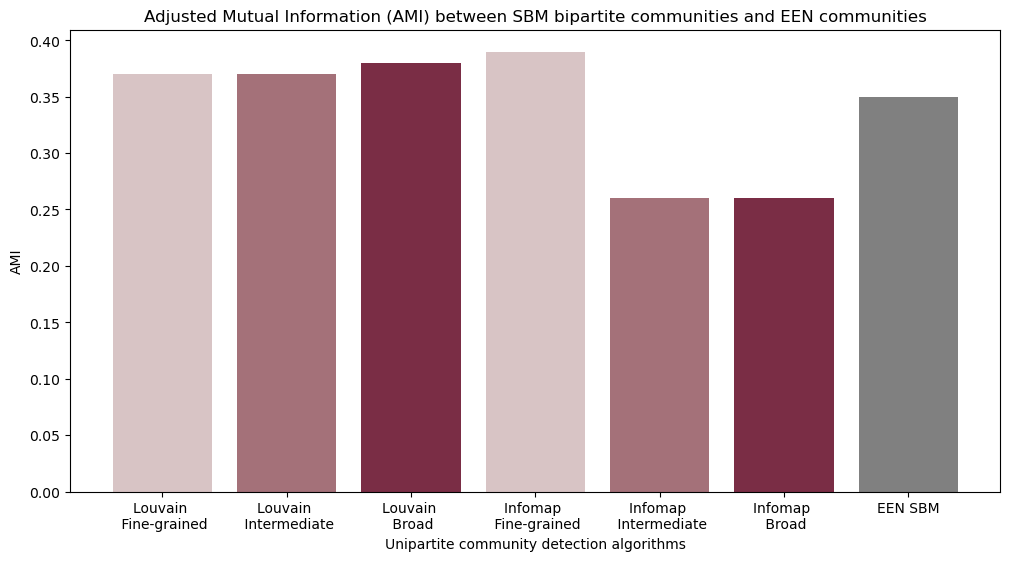

In [ ]:

data = [0.37,0.37,0.38,0.39,0.26,0.26,0.35]


# Labels for the x-axis
labels = ['Louvain \n Fine-grained', 'Louvain \n Intermediate', 'Louvain \n Broad',
          'Infomap \n Fine-grained', 'Infomap \n Intermediate', 'Infomap \n Broad',
          'EEN SBM'
         ]
color_list = ['#D8C4C5','#A47179','#7A2D45','#D8C4C5','#A47179','#7A2D45','grey']
fig, ax = plt.subplots(figsize=(12, 6))

# Create the rest of the bars
ax.bar(labels, data, color=color_list)

# Add titles and labels
plt.xlabel('Unipartite community detection algorithms')
plt.ylabel('AMI')
plt.title('Adjusted Mutual Information (AMI) between SBM bipartite communities and EEN communities')

plt.savefig('output/Figures/SBM_exposures_AMI.pdf',format='pdf',dpi=300, bbox_inches = "tight")
# Display the plot
plt.show()

In [30]:
data = [0.37,0.37,0.38,0.39,0.26,0.26,0.35]


# Labels for the x-axis
labels = ['Louvain \n Fine-grained', 'Louvain \n Intermediate', 'Louvain \n Broad',
          'Infomap \n Fine-grained', 'Infomap \n Intermediate', 'Infomap \n Broad',
          'EEN SBM'
         ]

rows = []


# Remaining single bars
for label, value in zip(labels[1:], data[1:]):
    rows.append({
        "Method": label,
        "Segment": "single",
        "Value": value,
        "Color": "black"
    })

source_df = pd.DataFrame(rows)

excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="new"
    ) as writer:

    source_df.to_excel(
        writer,
        sheet_name="SF28C",
        index=False
    )

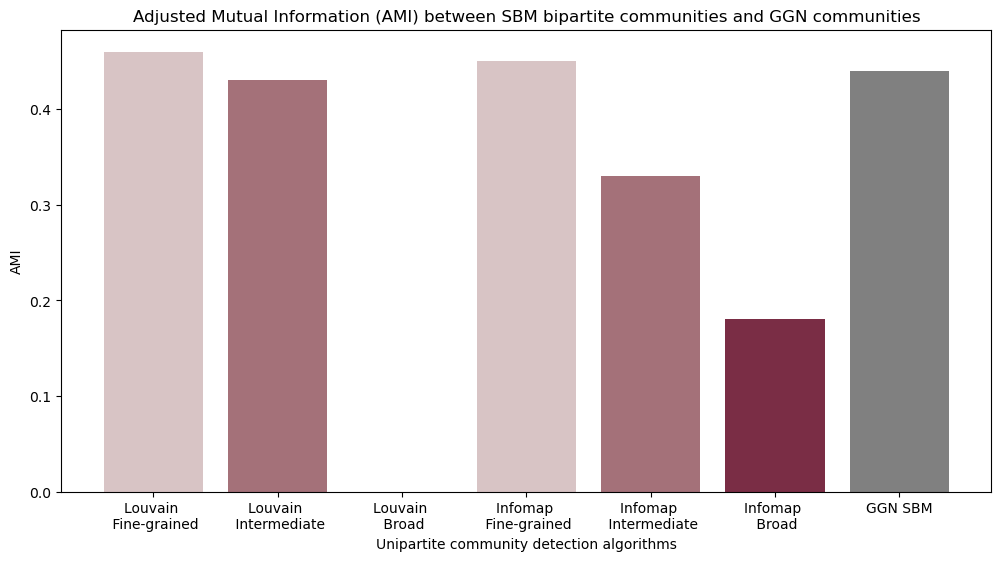

In [196]:
data = [0.46,0.43,0,0.45,0.33,0.18,0.44]


# Labels for the x-axis
labels = ['Louvain \n Fine-grained', 'Louvain \n Intermediate', 'Louvain \n Broad',
          'Infomap \n Fine-grained', 'Infomap \n Intermediate', 'Infomap \n Broad',
          'GGN SBM'
         ]
color_list = ['#D8C4C5','#A47179','#7A2D45','#D8C4C5','#A47179','#7A2D45','grey']
fig, ax = plt.subplots(figsize=(12, 6))

# Create the rest of the bars
ax.bar(labels, data, color=color_list)

# Add titles and labels
plt.xlabel('Unipartite community detection algorithms')
plt.ylabel('AMI')
plt.title('Adjusted Mutual Information (AMI) between SBM bipartite communities and GGN communities')

plt.savefig('output/SBM_genes_AMI.pdf',format='pdf',dpi=300, bbox_inches = "tight")
# Display the plot
plt.show()

In [31]:
data = [0.46,0.43,0,0.45,0.33,0.18,0.44]


# Labels for the x-axis
labels = ['Louvain \n Fine-grained', 'Louvain \n Intermediate', 'Louvain \n Broad',
          'Infomap \n Fine-grained', 'Infomap \n Intermediate', 'Infomap \n Broad',
          'GGN SBM'
         ]

rows = []


# Remaining single bars
for label, value in zip(labels[1:], data[1:]):
    rows.append({
        "Method": label,
        "Segment": "single",
        "Value": value,
        "Color": "black"
    })

source_df = pd.DataFrame(rows)

excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="new"
    ) as writer:

    source_df.to_excel(
        writer,
        sheet_name="SF28D",
        index=False
    )

In [32]:

#Let's prepare the communities for the enrichment

def read_gene_annotation(file_path):
    """
    Reads a gene annotation file and stores it as a dictionary.
    
    Parameters:
        file_path (str): Path to the input text file.
        
    Returns:
        dict: Dictionary where keys are annotations and values are lists of genes.
    """
    gene_dict = {}
    
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split('\t')  # Split by tab
            if len(parts) > 1:
                annotation = parts[0].strip()
                genes = [gene.strip() for gene in parts[1:] if gene.strip()]
                gene_dict[annotation] = genes
    
    return gene_dict

In [116]:
#Let's read the annotations files
MF2023_gene_dict = read_gene_annotation("Libraries/GO_Molecular_Function_2023.txt")
CC2023_gene_dict = read_gene_annotation("Libraries/GO_Cellular_Component_2023.txt")
BP2023_gene_dict = read_gene_annotation("Libraries/GO_Biological_Process_2023.txt")
Reactome2024_gene_dict = read_gene_annotation("Libraries/Reactome_Pathways_2024.txt")

In [117]:
tot_gene_annotation_dict = {**MF2023_gene_dict, **CC2023_gene_dict, **BP2023_gene_dict, **Reactome2024_gene_dict}

In [119]:
with open("Libraries/genetic_background.txt", "r") as file:
    genetic_background_list = [line.strip() for line in file]

In [124]:
backbone_exp_graph_significant_weighted = nx.read_weighted_edgelist("backbone_exp_graph_significant_weighted.edgelist")

In [126]:
#I consider a pre-rank for making a choice on the gene cutoff
#defining for each comunity a set of genes that is well-representative of each cluster
from collections import Counter
pre_rank_SBM_cluster_genelist={}
for com,explist in bipartite_sbm_clustering_dict_exposures.items():
    gene_list=[]
    rank_genelist=[]
    if len(explist)>1:
        G_sub = nx.subgraph(backbone_exp_graph_significant_weighted,explist)   #let's create the subgraph corresponding to the cluster
        for edge in G_sub.edges():
            overlap_geneset=chem_gene[edge[0]] & chem_gene[edge[1]]
            for gene in overlap_geneset:
                gene_list.append(gene)
        count_dict=Counter(gene_list)
        for gene in set(gene_list):
            rank_genelist.append([gene,count_dict[gene]])
    else:
        for gene in chem_gene[explist[0]]:
            rank_genelist.append([gene,1])
    pre_rank_SBM_cluster_genelist[com]=rank_genelist

pre_rank_SBM_cluster_genelist_df={}
for com,genelist in pre_rank_SBM_cluster_genelist.items():
    rank_df=pd.DataFrame(columns=('gene', 'rank'))
    for n in range(len(genelist)):
        rank_df.loc[n] = [genelist[n][0], float(genelist[n][1])]
    rank_df=rank_df.sort_values(by=['rank'],ascending=False)
    pre_rank_SBM_cluster_genelist_df[com]=rank_df


In [201]:
library_list = ["GO_Molecular_Function_2025","GO_Biological_Process_2025","GO_Cellular_Component_2025","Reactome_Pathways_2024"]
import gseapy as gp
def enr_ranking_leading_genes(pre_rank_df,library_list):   #This function returns the leading genes
    import gseapy as gp
    leading_genes_tot=[]
    for lib in library_list:
        c=0
        while c<10:
            try:
                lib_pre_res = gp.prerank(rnk=pre_rank_df, gene_sets=lib,
                                 processes=4,min_size=3,max_size=5000,outdir=None,   #we impose at least 5 enriched common genes
                                 permutation_num=500) # reduce number to speed up testing
                leading_gene_lib_list=[]
                for gene_str in lib_pre_res.res2d['Lead_genes'].tolist():    #lib_pre_res.res2d['Lead_genes'] if in the cluster
                    leading_gene_lib_list.extend(gene_str.split(";"))
                leading_genes_tot.extend(leading_gene_lib_list)
                if 'Lead_genes' in lib_pre_res.res2d:
                    break
            except (NameError, AttributeError):
                c += 1
    return set(leading_genes_tot)

In [202]:
#Let's associate for each community the most meaningful genes (those communities associated with more than 20 genes, we will use the leading genes of the ranked enrichment by frequency)
#Now we will run the traditional enrichment analysis for (Fisher's exact test + BH correction for those communties
#that perturb less than 20 genes, otherwise we will collect the leading genes from the GSEA with ranking
#and then performing again a traditional enrichment analysis

pre_rank_SBM_cluster_genes = {}


for com in list(pre_rank_SBM_cluster_genelist_df.keys()):
    num_of_genes=len(pre_rank_SBM_cluster_genelist_df[com])
    if num_of_genes>20:
        try:
            lead_genelist = list(enr_ranking_leading_genes(pre_rank_SBM_cluster_genelist_df[com],library_list))
            pre_rank_SBM_cluster_genes[com] = lead_genelist
        except:
            pre_rank_SBM_cluster_genes[com] = list(pre_rank_SBM_cluster_genelist_df[com]["gene"])
    else:
        pre_rank_SBM_cluster_genes[com] = list(pre_rank_SBM_cluster_genelist_df[com]["gene"])



/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_35902/3799714394.py:10: DeprecationWarning: processes is deprecated; use threads
  lib_pre_res = gp.prerank(rnk=pre_rank_df, gene_sets=lib,
2026-01-10 17:36:58,242 [WARNING] Duplicated values found in preranked stats: 94.96% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_35902/3799714394.py:10: DeprecationWarning: processes is deprecated; use threads
  lib_pre_res = gp.prerank(rnk=pre_rank_df, gene_sets=lib,
2026-01-10 17:36:58,294 [WARNING] Duplicated values found in preranked stats: 94.96% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_35902/3799714394.py:10: DeprecationWarning: processes is deprecated; use threads
  lib_pre_res = gp.prerank(rnk=pre_rank_df, gene_sets=lib,
2026-01-10 17:36:58,490 [WARNING] Duplicated values

In [203]:
with open("output/pre_rank_SBM_cluster_genes.json", "w") as f:
    json.dump(pre_rank_SBM_cluster_genes, f)

In [33]:
#Let's import the enrichments

with open("output/SBM_ora_dict.json", "r") as handle:
    SBM_ora_dict = json.load(handle)

with open("output/SBM_reactome_ora_dict.json", "r") as handle:
    SBM_reactome_ora_dict = json.load(handle)

In [39]:
sbm_enr_list = []
for com,enr_df_list in SBM_ora_dict.items():
    for el in range(len(enr_df_list)):
        enr_dict = enr_df_list[el]
        if float(enr_dict['FDR'])<0.05:
            sbm_enr_list.append(enr_dict['Description'])
for com,enr_df_list in SBM_reactome_ora_dict.items():
    for el in range(len(enr_df_list)):
        enr_dict = enr_df_list[el]
        if float(enr_dict['FDR'])<0.05:
            sbm_enr_list.append(enr_dict['Description'])

from collections import (defaultdict,Counter)
sbm_enr_counter_dict = dict(Counter(sbm_enr_list).most_common())

In [36]:
#Let's import the original Louvain enrichments


with open("output/Communities/Louvain/first_louvain_ora_dict.json", "r") as handle:
    louvain_fine_grained_ora_dict = json.load(handle)

with open("output/Communities/Louvain/second_louvain_cluster_ora_dict.json", 'rb') as handle:
    louvain_middle_ora_dict = json.load(handle)

with open("output/Communities/Louvain/third_louvain_cluster_ora_dict.json", 'rb') as handle:
    louvain_broad_ora_dict = json.load(handle)

with open("output/Communities/Louvain/first_louvain_ora_reactome_dict.json", "r") as handle:
    louvain_fine_grained_ora_reactome_dict = json.load(handle)

with open("output/Communities/Louvain/second_louvain_cluster_ora_reactome_dict.json", 'rb') as handle:
    louvain_middle_ora_reactome_dict = json.load(handle)

with open("output/Communities/Louvain/third_louvain_cluster_ora_reactome_dict.json", 'rb') as handle:
    louvain_broad_ora_reactome_dict = json.load(handle)

In [37]:
louvain_fine_grained_enr_list = []
for com,enr_df_list in louvain_fine_grained_ora_dict.items():
    for el in range(len(enr_df_list)):
        enr_dict = enr_df_list[el]
        if float(enr_dict['FDR'])<0.05:
            louvain_fine_grained_enr_list.append(enr_dict['Description'])
for com,enr_df_list in louvain_fine_grained_ora_reactome_dict.items():
    for el in range(len(enr_df_list)):
        enr_dict = enr_df_list[el]
        if float(enr_dict['FDR'])<0.05:
            louvain_fine_grained_enr_list.append(enr_dict['Description'])

from collections import (defaultdict,Counter)
louvain_fine_grained_enr_counter_dict = dict(Counter(louvain_fine_grained_enr_list).most_common())

louvain_middle_enr_list = []
for com,enr_df_list in louvain_middle_ora_dict.items():
    for el in range(len(enr_df_list)):
        enr_dict = enr_df_list[el]
        if float(enr_dict['FDR'])<0.05:
            louvain_middle_enr_list.append(enr_dict['Description'])
for com,enr_df_list in louvain_middle_ora_reactome_dict.items():
    for el in range(len(enr_df_list)):
        enr_dict = enr_df_list[el]
        if float(enr_dict['FDR'])<0.05:
            louvain_middle_enr_list.append(enr_dict['Description'])

from collections import (defaultdict,Counter)
louvain_middle_enr_counter_dict = dict(Counter(louvain_middle_enr_list).most_common())


louvain_broad_enr_list = []
for com,enr_df_list in louvain_broad_ora_dict.items():
    for el in range(len(enr_df_list)):
        enr_dict = enr_df_list[el]
        if float(enr_dict['FDR'])<0.05:
            louvain_broad_enr_list.append(enr_dict['Description'])
for com,enr_df_list in louvain_broad_ora_reactome_dict.items():
    for el in range(len(enr_df_list)):
        enr_dict = enr_df_list[el]
        if float(enr_dict['FDR'])<0.05:
            louvain_broad_enr_list.append(enr_dict['Description'])

from collections import (defaultdict,Counter)
louvain_broad_enr_counter_dict = dict(Counter(louvain_broad_enr_list).most_common())

In [40]:

sbm_exp_frequency_list_vsfg = []
sbm_exp_frequency_list_vsm = []
sbm_exp_frequency_list_vsb = []
fine_grained_louvain_communities = []
middle_louvain_communities = []
broad_louvain_communities = []

for exp,fr in sbm_enr_counter_dict.items():
    try:
        fine_grained_louvain_communities.append(louvain_fine_grained_enr_counter_dict[exp])
        sbm_exp_frequency_list_vsfg.append(fr)
    except:
        pass
    try:
        middle_louvain_communities.append(louvain_middle_enr_counter_dict[exp])
        sbm_exp_frequency_list_vsm.append(fr)
    except:
        pass
    try:
        broad_louvain_communities.append(louvain_broad_enr_counter_dict[exp])
        sbm_exp_frequency_list_vsb.append(fr)
    except:
        pass


Fine-grained:0.8543616356234885
Intermediate:0.8167710585856913
Broad:0.45662016877881484


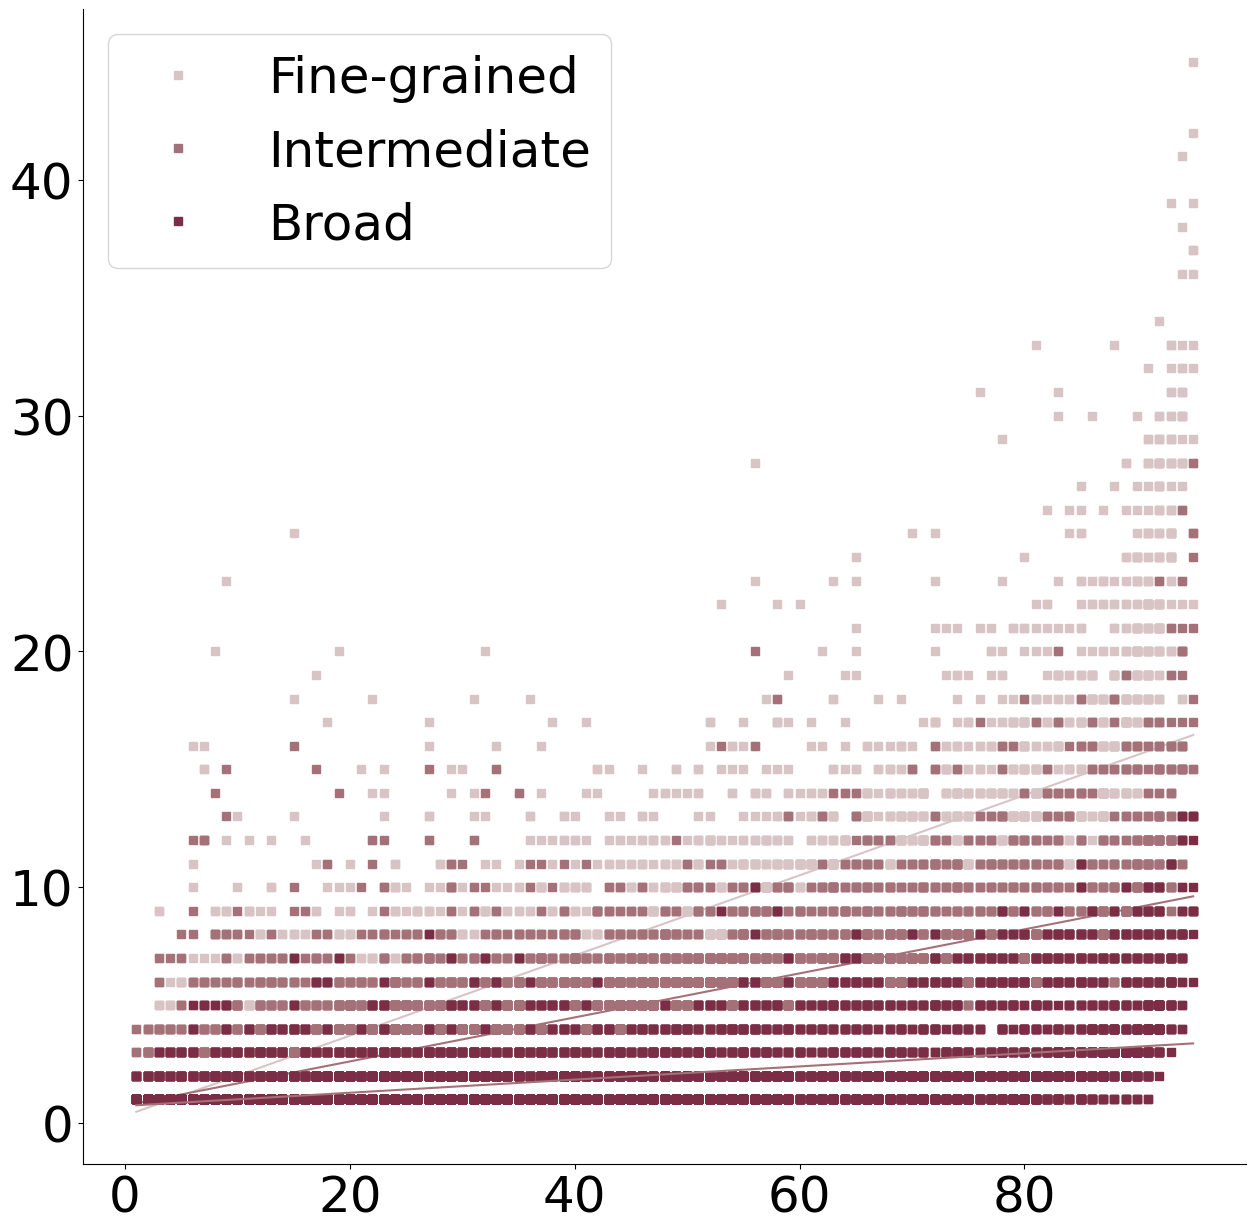

In [ ]:
#Let's perform a correlation of the top frequently enriched exposures

import scipy
from matplotlib.pyplot import figure
from scipy import stats





fig, ax = plt.subplots(figsize=(15,15))
slope, intercept, r, p, stderr = scipy.stats.linregress(sbm_exp_frequency_list_vsfg, fine_grained_louvain_communities)
print("Fine-grained:%s"%r)

ax.plot(sbm_exp_frequency_list_vsfg,fine_grained_louvain_communities, linewidth=0, marker='s',c='#D8C4C5', label='Fine-grained')
y=[]
for i in sbm_exp_frequency_list_vsfg:
    g=(intercept + slope * i)
    y.append(g)
line = "Fine-grained" 

ax.plot(sbm_exp_frequency_list_vsfg, y,c='#D8C4C5')

slope, intercept, r, p, stderr = scipy.stats.linregress(sbm_exp_frequency_list_vsm, middle_louvain_communities)
print("Intermediate:%s"%r)
ax.plot(sbm_exp_frequency_list_vsm,middle_louvain_communities, linewidth=0, marker='s',c='#A47179', label='Intermediate')
y=[]
for i in sbm_exp_frequency_list_vsm:
    g=(intercept + slope * i)
    y.append(g)
line = "Intermediate" 

ax.plot(sbm_exp_frequency_list_vsm, y,c='#A47179')

slope, intercept, r, p, stderr = scipy.stats.linregress(sbm_exp_frequency_list_vsb, broad_louvain_communities)
print("Broad:%s"%r)
ax.plot(sbm_exp_frequency_list_vsb,broad_louvain_communities, linewidth=0, marker='s',c='#7A2D45', label='Broad')

y=[]
for i in sbm_exp_frequency_list_vsb:
    g=(intercept + slope * i)
    y.append(g)
line = "Broad" 

ax.plot(sbm_exp_frequency_list_vsb, y,c='#A47179')



ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xticks(fontsize=36) 
plt.yticks(fontsize=36) 

ax.legend(facecolor='white',fontsize=36)
plt.savefig('output/Correlation_Louvain_EEN_Enriched_Communities.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.savefig('output/Correlation_Louvain_EEN_Enriched_Communities.png',format='png',dpi=300, bbox_inches = "tight")
plt.show()

In [41]:
# ================================
# Build source data table
# ================================

records = []

# Fine-grained
for x, y in zip(sbm_exp_frequency_list_vsfg, fine_grained_louvain_communities):
    records.append({
        "Hierarchy": "Fine-grained",
        "SBM_frequency": x,
        "Louvain_frequency": y
    })

# Intermediate
for x, y in zip(sbm_exp_frequency_list_vsm, middle_louvain_communities):
    records.append({
        "Hierarchy": "Intermediate",
        "SBM_frequency": x,
        "Louvain_frequency": y
    })

# Broad
for x, y in zip(sbm_exp_frequency_list_vsb, broad_louvain_communities):
    records.append({
        "Hierarchy": "Broad",
        "SBM_frequency": x,
        "Louvain_frequency": y
    })

df_corr_source = pd.DataFrame(records)

print("Total data points:", len(df_corr_source))

# ================================
# Save into existing Source Data file
# ================================

out_file = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(out_file,
                    engine="openpyxl",
                    mode="a",
                    if_sheet_exists="replace") as writer:

    df_corr_source.to_excel(
        writer,
        sheet_name="SF29A",
        index=False
    )

print("Correlation source data saved successfully.")

Total data points: 24597
Correlation source data saved successfully.


In [42]:
#Infomap

#Let's import the original Infomap enrichments


with open("output/Communities/Infomap/first_infomap_ora_dict.json", "r") as handle:
    infomap_fine_grained_ora_dict = json.load(handle)

with open("output/Communities/Infomap/second_infomap_cluster_ora_dict.json", 'rb') as handle:
    infomap_middle_ora_dict = json.load(handle)

with open("output/Communities/Infomap/third_infomap_cluster_ora_dict.json", 'rb') as handle:
    infomap_broad_ora_dict = json.load(handle)

with open("output/Communities/Infomap/first_infomap_ora_reactome_dict.json", "r") as handle:
    infomap_fine_grained_ora_reactome_dict = json.load(handle)

with open("output/Communities/Infomap/second_infomap_cluster_ora_reactome_dict.json", 'rb') as handle:
    infomap_middle_ora_reactome_dict = json.load(handle)

with open("output/Communities/Infomap/third_infomap_cluster_ora_reactome_dict.json", 'rb') as handle:
    infomap_broad_ora_reactome_dict = json.load(handle)



In [43]:
infomap_fine_grained_enr_list = []
for com,enr_df_list in infomap_fine_grained_ora_dict.items():
    for el in range(len(enr_df_list)):
        enr_dict = enr_df_list[el]
        if float(enr_dict['FDR'])<0.05:
            infomap_fine_grained_enr_list.append(enr_dict['Description'])
for com,enr_df_list in infomap_fine_grained_ora_reactome_dict.items():
    for el in range(len(enr_df_list)):
        enr_dict = enr_df_list[el]
        if float(enr_dict['FDR'])<0.05:
            infomap_fine_grained_enr_list.append(enr_dict['Description'])

from collections import (defaultdict,Counter)
infomap_fine_grained_enr_counter_dict = dict(Counter(infomap_fine_grained_enr_list).most_common())

infomap_middle_enr_list = []
for com,enr_df_list in infomap_middle_ora_dict.items():
    for el in range(len(enr_df_list)):
        enr_dict = enr_df_list[el]
        if float(enr_dict['FDR'])<0.05:
            infomap_middle_enr_list.append(enr_dict['Description'])
for com,enr_df_list in infomap_middle_ora_reactome_dict.items():
    for el in range(len(enr_df_list)):
        enr_dict = enr_df_list[el]
        if float(enr_dict['FDR'])<0.05:
            infomap_middle_enr_list.append(enr_dict['Description'])

from collections import (defaultdict,Counter)
infomap_middle_enr_counter_dict = dict(Counter(infomap_middle_enr_list).most_common())

infomap_broad_enr_list = []
for com,enr_df_list in infomap_broad_ora_dict.items():
    for el in range(len(enr_df_list)):
        enr_dict = enr_df_list[el]
        if float(enr_dict['FDR'])<0.05:
            infomap_broad_enr_list.append(enr_dict['Description'])
for com,enr_df_list in infomap_broad_ora_reactome_dict.items():
    for el in range(len(enr_df_list)):
        enr_dict = enr_df_list[el]
        if float(enr_dict['FDR'])<0.05:
            infomap_broad_enr_list.append(enr_dict['Description'])
            
from collections import (defaultdict,Counter)
infomap_broad_enr_counter_dict = dict(Counter(infomap_broad_enr_list).most_common())

In [44]:
sbm_exp_frequency_list_vsfg = []
sbm_exp_frequency_list_vsm = []
sbm_exp_frequency_list_vsb = []
fine_grained_infomap_communities = []
middle_infomap_communities = []
broad_infomap_communities = []

for exp,fr in sbm_enr_counter_dict.items():
    try:
        fine_grained_infomap_communities.append(infomap_fine_grained_enr_counter_dict[exp])
        sbm_exp_frequency_list_vsfg.append(fr)
    except:
        pass
    try:
        middle_infomap_communities.append(infomap_middle_enr_counter_dict[exp])
        sbm_exp_frequency_list_vsm.append(fr)
    except:
        pass
    try:
        broad_infomap_communities.append(infomap_broad_enr_counter_dict[exp])
        sbm_exp_frequency_list_vsb.append(fr)
    except:
        pass


Fine-grained:0.8389460037046402
Intermediate:0.6724741833754878
Broad:0.7008406055013303


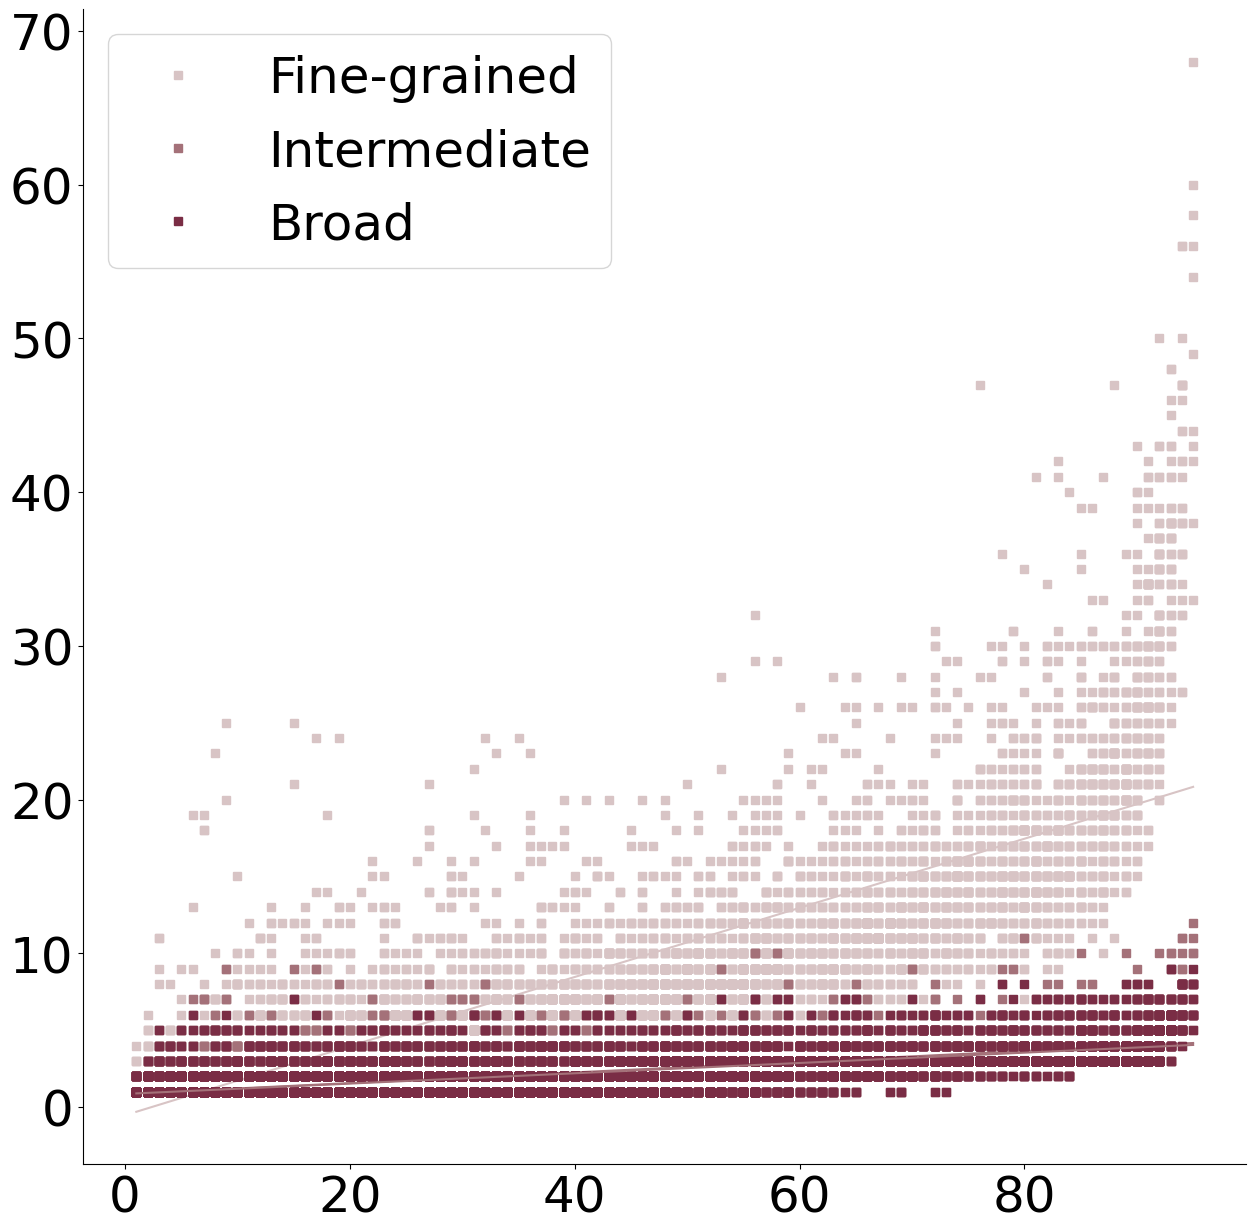

In [ ]:
#Let's perform a correlation of the top frequently enriched exposures

import scipy
from matplotlib.pyplot import figure
from scipy import stats





fig, ax = plt.subplots(figsize=(15,15))
slope, intercept, r, p, stderr = scipy.stats.linregress(sbm_exp_frequency_list_vsfg, fine_grained_infomap_communities)
print("Fine-grained:%s"%r)

ax.plot(sbm_exp_frequency_list_vsfg,fine_grained_infomap_communities, linewidth=0, marker='s',c='#D8C4C5', label='Fine-grained')
y=[]
for i in sbm_exp_frequency_list_vsfg:
    g=(intercept + slope * i)
    y.append(g)
line = "Fine-grained" 

ax.plot(sbm_exp_frequency_list_vsfg, y,c='#D8C4C5')

slope, intercept, r, p, stderr = scipy.stats.linregress(sbm_exp_frequency_list_vsm, middle_infomap_communities)
print("Intermediate:%s"%r)
ax.plot(sbm_exp_frequency_list_vsm,middle_infomap_communities, linewidth=0, marker='s',c='#A47179', label='Intermediate')
y=[]
for i in sbm_exp_frequency_list_vsm:
    g=(intercept + slope * i)
    y.append(g)
line = "Intermediate" 

ax.plot(sbm_exp_frequency_list_vsm, y,c='#A47179')

slope, intercept, r, p, stderr = scipy.stats.linregress(sbm_exp_frequency_list_vsb, broad_infomap_communities)
print("Broad:%s"%r)
ax.plot(sbm_exp_frequency_list_vsb,broad_infomap_communities, linewidth=0, marker='s',c='#7A2D45', label='Broad')

y=[]
for i in sbm_exp_frequency_list_vsb:
    g=(intercept + slope * i)
    y.append(g)
line = "Broad" 

ax.plot(sbm_exp_frequency_list_vsb, y,c='#A47179')



ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xticks(fontsize=36) 
plt.yticks(fontsize=36) 

ax.legend(facecolor='white',fontsize=36)
plt.savefig('output/Correlation_Infomap_EEN_Enriched_Communities.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.savefig('output/Correlation_Infomap_EEN_Enriched_Communities.png',format='png',dpi=300, bbox_inches = "tight")
plt.show()

In [45]:
# ================================
# Build source data table
# ================================

records = []

# Fine-grained
for x, y in zip(sbm_exp_frequency_list_vsfg, fine_grained_infomap_communities):
    records.append({
        "Hierarchy": "Fine-grained",
        "SBM_frequency": x,
        "Infomap_frequency": y
    })

# Intermediate
for x, y in zip(sbm_exp_frequency_list_vsm, middle_infomap_communities):
    records.append({
        "Hierarchy": "Intermediate",
        "SBM_frequency": x,
        "Infomap_frequency": y
    })

# Broad
for x, y in zip(sbm_exp_frequency_list_vsb, broad_infomap_communities):
    records.append({
        "Hierarchy": "Broad",
        "SBM_frequency": x,
        "Infomap_frequency": y
    })

df_corr_source = pd.DataFrame(records)

print("Total data points:", len(df_corr_source))

# ================================
# Save into existing Source Data file
# ================================

out_file = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(out_file,
                    engine="openpyxl",
                    mode="a",
                    if_sheet_exists="replace") as writer:

    df_corr_source.to_excel(
        writer,
        sheet_name="SF29B",
        index=False
    )

print("Correlation source data saved successfully.")

Total data points: 28975
Correlation source data saved successfully.


In [246]:
#SBM EEN
#I consider a pre-rank for making a choice on the gene cutoff
#defining for each comunity a set of genes that is well-representative of each cluster
from collections import Counter
pre_rank_SBM_EEN_cluster_genelist={}
for com,explist in SBM_EEN_communities_dict.items():
    gene_list=[]
    rank_genelist=[]
    if len(explist)>1:
        G_sub = nx.subgraph(backbone_exp_graph_significant_weighted,explist)   #let's create the subgraph corresponding to the cluster
        for edge in G_sub.edges():
            overlap_geneset=chem_gene[edge[0]] & chem_gene[edge[1]]
            for gene in overlap_geneset:
                gene_list.append(gene)
        count_dict=Counter(gene_list)
        for gene in set(gene_list):
            rank_genelist.append([gene,count_dict[gene]])
    else:
        for gene in chem_gene[explist[0]]:
            rank_genelist.append([gene,1])
    pre_rank_SBM_EEN_cluster_genelist[com]=rank_genelist

pre_rank_SBM_EEN_cluster_genelist_df={}
for com,genelist in pre_rank_SBM_EEN_cluster_genelist.items():
    rank_df=pd.DataFrame(columns=('gene', 'rank'))
    for n in range(len(genelist)):
        rank_df.loc[n] = [genelist[n][0], float(genelist[n][1])]
    rank_df=rank_df.sort_values(by=['rank'],ascending=False)
    pre_rank_SBM_EEN_cluster_genelist_df[com]=rank_df

In [250]:

pre_rank_SBM_EEN_cluster_genes = {}

for com in list(pre_rank_SBM_EEN_cluster_genelist_df.keys()):
    num_of_genes=len(pre_rank_SBM_EEN_cluster_genelist_df[com])
    if num_of_genes>20:
        try:
            lead_genelist = list(enr_ranking_leading_genes(pre_rank_SBM_EEN_cluster_genelist_df[com],library_list))
            pre_rank_SBM_EEN_cluster_genes[com] = lead_genelist
        except:
            pre_rank_SBM_EEN_cluster_genes[com] = list(pre_rank_SBM_EEN_cluster_genelist_df[com]["gene"])
    else:
        pre_rank_SBM_EEN_cluster_genes[com] = list(pre_rank_SBM_EEN_cluster_genelist_df[com]["gene"])



/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_35902/3799714394.py:10: DeprecationWarning: processes is deprecated; use threads
  lib_pre_res = gp.prerank(rnk=pre_rank_df, gene_sets=lib,
2026-01-10 19:42:21,708 [WARNING] Duplicated values found in preranked stats: 58.14% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_35902/3799714394.py:10: DeprecationWarning: processes is deprecated; use threads
  lib_pre_res = gp.prerank(rnk=pre_rank_df, gene_sets=lib,
2026-01-10 19:42:21,734 [WARNING] Duplicated values found in preranked stats: 58.14% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_35902/3799714394.py:10: DeprecationWarning: processes is deprecated; use threads
  lib_pre_res = gp.prerank(rnk=pre_rank_df, gene_sets=lib,
2026-01-10 19:42:21,797 [WARNING] Duplicated values

In [254]:
pre_rank_SBM_EEN_cluster_genes_str = {}
for con,genes in pre_rank_SBM_EEN_cluster_genes.items():
    pre_rank_SBM_EEN_cluster_genes_str[str(con)] = genes

with open("output/pre_rank_SBM_EEN_cluster_genes.json", "w") as f:
    json.dump(pre_rank_SBM_EEN_cluster_genes_str, f)

In [46]:
#Let's import the enrichments

with open("output/SBM_EEN_ora_dict.json", "r") as handle:
    SBM_EEN_ora_dict = json.load(handle)

with open("output/SBM_EEN_reactome_ora_dict.json", "r") as handle:
    SBM_EEN_reactome_ora_dict = json.load(handle)

In [47]:
sbm_een_enr_list = []
for com,enr_df_list in SBM_EEN_ora_dict.items():
    for el in range(len(enr_df_list)):
        enr_dict = enr_df_list[el]
        if float(enr_dict['FDR'])<0.05:
            sbm_een_enr_list.append(enr_dict['Description'])
for com,enr_df_list in SBM_EEN_reactome_ora_dict.items():
    for el in range(len(enr_df_list)):
        enr_dict = enr_df_list[el]
        if float(enr_dict['FDR'])<0.05:
            sbm_een_enr_list.append(enr_dict['Description'])
            
from collections import (defaultdict,Counter)
sbm_een_enr_counter_dict = dict(Counter(sbm_een_enr_list).most_common())

In [48]:

sbm_exp_frequency_list_vssbm_een = []
sbm_een_communities = []

for exp,fr in sbm_enr_counter_dict.items():
    try:
        sbm_een_communities.append(sbm_een_enr_counter_dict[exp])
        sbm_exp_frequency_list_vssbm_een.append(fr)
    except:
        pass

SBM:0.9099586432926451


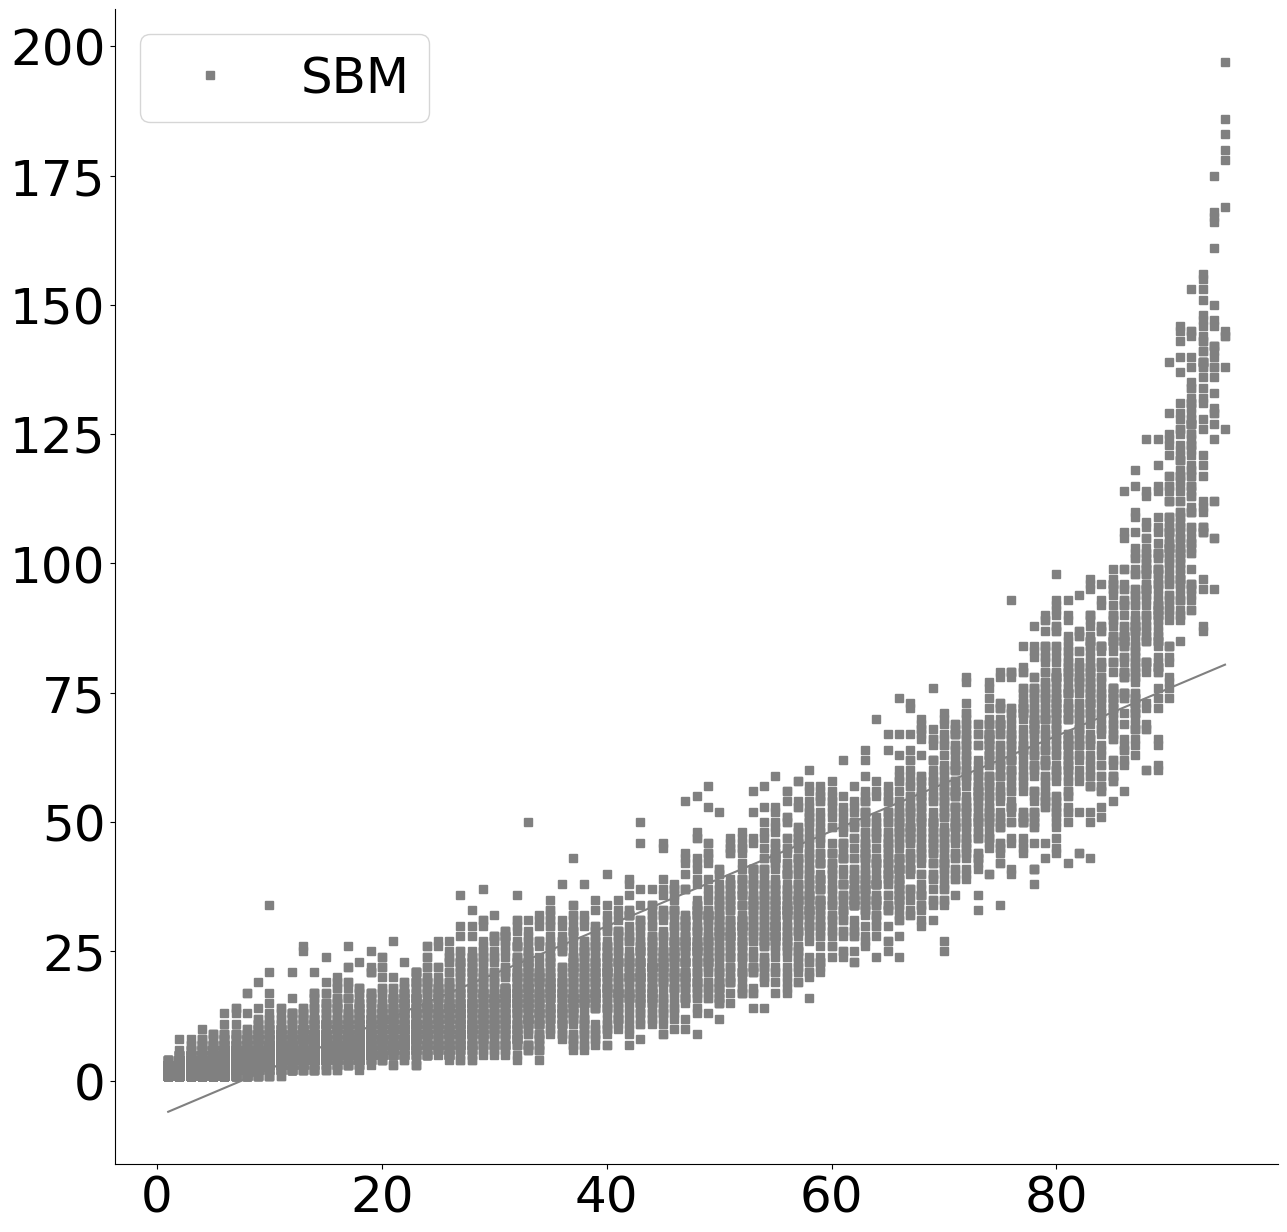

In [ ]:
#Let's perform a correlation of the top frequently enriched exposures

import scipy
from matplotlib.pyplot import figure
from scipy import stats



fig, ax = plt.subplots(figsize=(15,15))
slope, intercept, r, p, stderr = scipy.stats.linregress(sbm_exp_frequency_list_vssbm_een, sbm_een_communities)
print("SBM:%s"%r)

ax.plot(sbm_exp_frequency_list_vssbm_een,sbm_een_communities, linewidth=0, marker='s',c='grey', label='SBM')
y=[]
for i in sbm_exp_frequency_list_vssbm_een:
    g=(intercept + slope * i)
    y.append(g)
line = "SBM" 
ax.plot(sbm_exp_frequency_list_vssbm_een, y,c='grey')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xticks(fontsize=36) 
plt.yticks(fontsize=36) 

ax.legend(facecolor='white',fontsize=36)
plt.savefig('output/Correlation_SBM_EEN_Enriched_Communities.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.savefig('output/Correlation_SBM_EEN_Enriched_Communities.png',format='png',dpi=300, bbox_inches = "tight")
plt.show()

In [321]:
sbm_exp_counter_dict['D000082']

37

In [317]:
set(list(significant_gg_Infomap_fine_grained_dict_exp_counter_dict.keys())[:10]) & set(list(significant_gg_Louvain_fine_grained_dict_exp_counter_dict.keys())[:10]) 

{'C492448', 'D000082', 'D001564'}

In [319]:
sbm_exp_counter_dict

{'D000077185': 42,
 'D011794': 42,
 'D013749': 41,
 'C017947': 39,
 'C006780': 39,
 'D000082': 37,
 'D004958': 37,
 'D014212': 37,
 'D006861': 36,
 'D011374': 36,
 'D000077237': 36,
 'C018021': 36,
 'D016572': 36,
 'D004317': 36,
 'D052638': 35,
 'D003300': 35,
 'D002945': 35,
 'D019833': 34,
 'D014028': 33,
 'D000111': 33,
 'D003907': 33,
 'D000077154': 32,
 'D002117': 31,
 'D014635': 31,
 'D001151': 30,
 'D001241': 30,
 'D001564': 30,
 'D003474': 30,
 'D000077288': 30,
 'D000431': 30,
 'C561695': 29,
 'D008727': 29,
 'D009532': 29,
 'D013755': 29,
 'D015123': 29,
 'D019256': 29,
 'C023036': 29,
 'D020122': 29,
 'C113580': 29,
 'C093973': 29,
 'D013629': 29,
 'D001205': 28,
 'D002104': 28,
 'C496492': 28,
 'D019327': 28,
 'D004008': 28,
 'D000077267': 28,
 'D010100': 28,
 'C093642': 28,
 'D019821': 28,
 'D009538': 27,
 'D015032': 27,
 'D015655': 27,
 'C072553': 27,
 'C045651': 27,
 'D005472': 27,
 'D002220': 27,
 'D008687': 27,
 'D001335': 26,
 'D007213': 26,
 'D017239': 26,
 'D000077

In [49]:
# ================================
# Build source data table
# ================================


records = []

# Fine-grained
for x, y in zip(sbm_exp_frequency_list_vssbm_een, sbm_een_communities):
    records.append({
        "SBM_frequency": x,
        "SBM_EEN_frequency": y
    })

df_corr_source = pd.DataFrame(records)

print("Total data points:", len(df_corr_source))

# ================================
# Save into existing Source Data file
# ================================

out_file = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(out_file,
                    engine="openpyxl",
                    mode="a",
                    if_sheet_exists="replace") as writer:

    df_corr_source.to_excel(
        writer,
        sheet_name="SF29C",
        index=False
    )

print("Correlation source data saved successfully.")

Total data points: 10505
Correlation source data saved successfully.


In [ ]:
#GGN Enrichment

In [50]:
significant_bipartite_sbm_clustering_dict_genes = {}
for com,gene_set in bipartite_sbm_clustering_dict_genes.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene.items():
        raw_pval=float(overlap_set(set(gene_set), set(geneset), len(gene_map)))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()),0.05)
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_bipartite_sbm_clustering_dict_genes[com]= significant_chem_class

In [51]:
sbm_exp_list = []
for com,exp_list in significant_bipartite_sbm_clustering_dict_genes.items():
    for el in range(len(exp_list)):
        sbm_exp_list.append(exp_list[el][0])

from collections import (defaultdict,Counter)
sbm_exp_counter_dict = dict(Counter(sbm_exp_list).most_common())

In [60]:
significant_gg_Louvain_fine_grained_dict ={}
for com,gene_set in gg_Louvain_fine_grained_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene.items():
        raw_pval=float(overlap_set(set(gene_set), set(geneset), len(gene_map)))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()),0.05)
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_Louvain_fine_grained_dict[com]= significant_chem_class
    
significant_gg_Louvain_middle_dict = {}
for com,gene_set in gg_Louvain_middle_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene.items():
        raw_pval=float(overlap_set(set(gene_set), set(geneset), len(gene_map)))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()),0.05)
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_Louvain_middle_dict[com]= significant_chem_class
    
significant_gg_Louvain_broad_dict = {}
for com,gene_set in gg_Louvain_broad_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene.items():
        raw_pval=float(overlap_set(set(gene_set), set(geneset), len(gene_map)))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()),0.05)
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_Louvain_broad_dict[com]= significant_chem_class

In [61]:
significant_gg_Louvain_fine_grained_dict_exp_list = []
for com,exp_list in significant_gg_Louvain_fine_grained_dict.items():
    for el in range(len(exp_list)):
        significant_gg_Louvain_fine_grained_dict_exp_list.append(exp_list[el][0])

from collections import (defaultdict,Counter)
significant_gg_Louvain_fine_grained_dict_exp_counter_dict = dict(Counter(significant_gg_Louvain_fine_grained_dict_exp_list).most_common())



In [62]:
significant_gg_Louvain_middle_dict_exp_list = []
for com,exp_list in significant_gg_Louvain_middle_dict.items():
    for el in range(len(exp_list)):
        significant_gg_Louvain_middle_dict_exp_list.append(exp_list[el][0])

from collections import (defaultdict,Counter)
significant_gg_Louvain_middle_dict_exp_counter_dict = dict(Counter(significant_gg_Louvain_middle_dict_exp_list).most_common())


In [63]:
significant_gg_Louvain_broad_dict_exp_list = []
for com,exp_list in significant_gg_Louvain_broad_dict.items():
    for el in range(len(exp_list)):
        significant_gg_Louvain_broad_dict_exp_list.append(exp_list[el][0])

from collections import (defaultdict,Counter)
significant_gg_Louvain_broad_dict_exp_counter_dict = dict(Counter(significant_gg_Louvain_broad_dict_exp_list).most_common())

In [64]:
sbm_exp_frequency_list_vsfg = []
sbm_exp_frequency_list_vsm = []
sbm_exp_frequency_list_vsb = []
fine_grained_louvain_communities = []
middle_louvain_communities = []
broad_louvain_communities = []

for exp,fr in sbm_exp_counter_dict.items():
    try:
        fine_grained_louvain_communities.append(significant_gg_Louvain_fine_grained_dict_exp_counter_dict[exp])
        sbm_exp_frequency_list_vsfg.append(fr)
    except:
        pass
    try:
        middle_louvain_communities.append(significant_gg_Louvain_middle_dict_exp_counter_dict[exp])
        sbm_exp_frequency_list_vsm.append(fr)
    except:
        pass
    try:
        broad_louvain_communities.append(significant_gg_Louvain_broad_dict_exp_counter_dict[exp])
        sbm_exp_frequency_list_vsb.append(fr)
    except:
        pass


Fine-grained:0.7457871192726099
Intermediate:0.5253929485502886
Broad:0.0


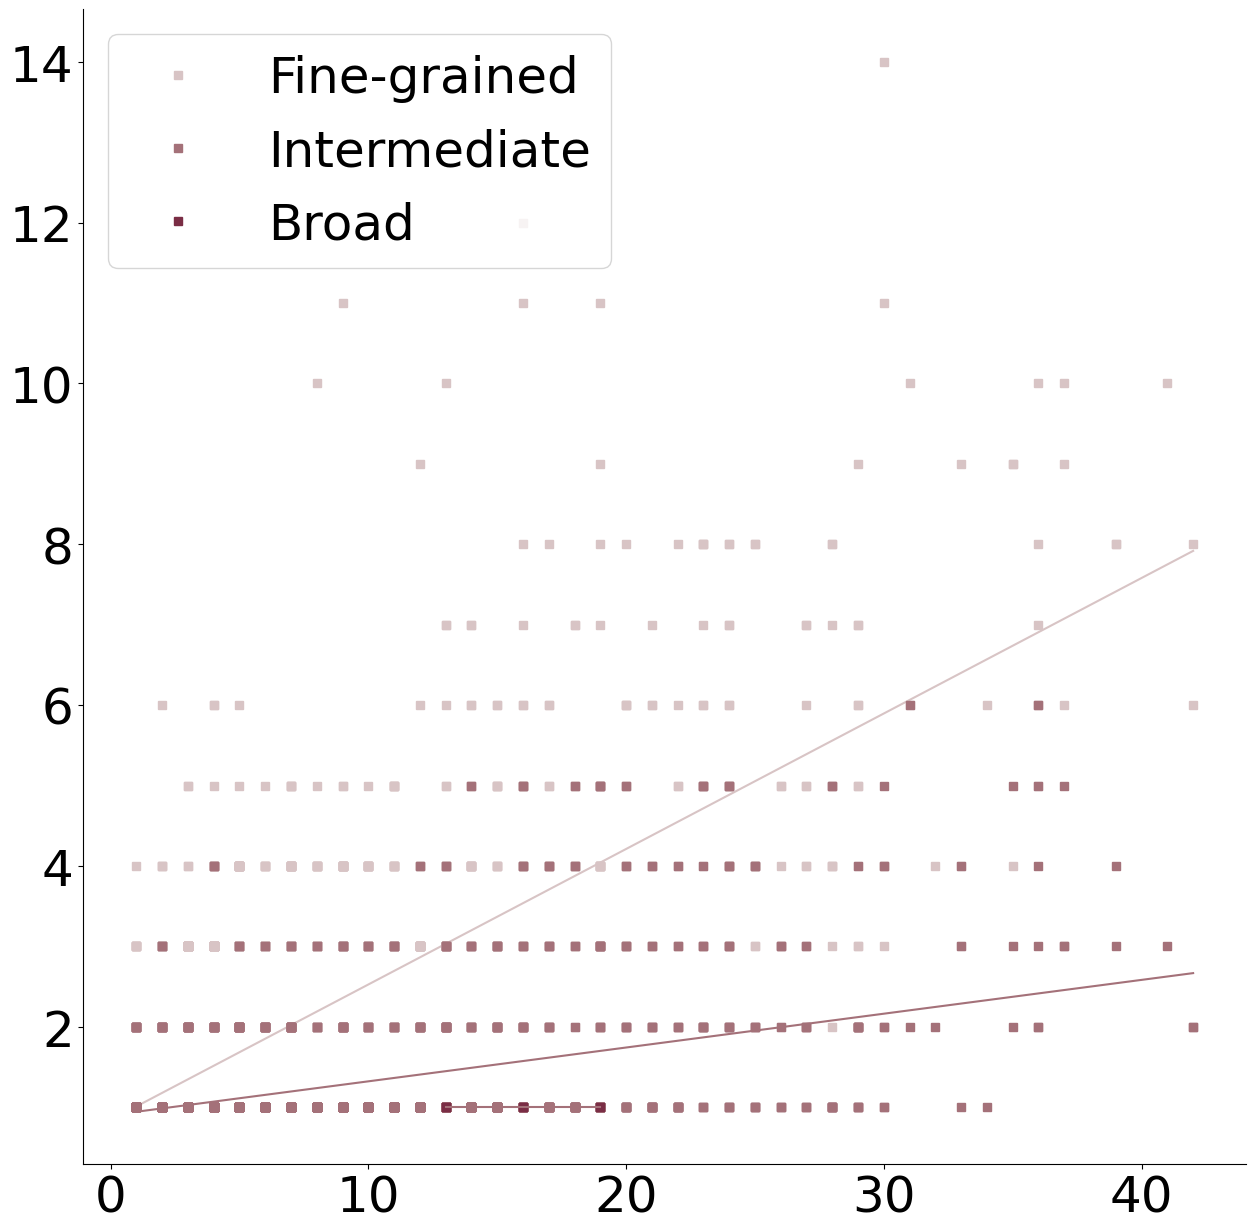

In [65]:
#Let's perform a correlation of the top frequently enriched exposures

import scipy
from matplotlib.pyplot import figure
from scipy import stats



fig, ax = plt.subplots(figsize=(15,15))
slope, intercept, r, p, stderr = scipy.stats.linregress(sbm_exp_frequency_list_vsfg, fine_grained_louvain_communities)
print("Fine-grained:%s"%r)

ax.plot(sbm_exp_frequency_list_vsfg,fine_grained_louvain_communities, linewidth=0, marker='s',c='#D8C4C5', label='Fine-grained')
y=[]
for i in sbm_exp_frequency_list_vsfg:
    g=(intercept + slope * i)
    y.append(g)
line = "Fine-grained" 

ax.plot(sbm_exp_frequency_list_vsfg, y,c='#D8C4C5')

slope, intercept, r, p, stderr = scipy.stats.linregress(sbm_exp_frequency_list_vsm, middle_louvain_communities)
print("Intermediate:%s"%r)
ax.plot(sbm_exp_frequency_list_vsm,middle_louvain_communities, linewidth=0, marker='s',c='#A47179', label='Intermediate')
y=[]
for i in sbm_exp_frequency_list_vsm:
    g=(intercept + slope * i)
    y.append(g)
line = "Intermediate" 

ax.plot(sbm_exp_frequency_list_vsm, y,c='#A47179')

slope, intercept, r, p, stderr = scipy.stats.linregress(sbm_exp_frequency_list_vsb, broad_louvain_communities)
print("Broad:%s"%r)
ax.plot(sbm_exp_frequency_list_vsb,broad_louvain_communities, linewidth=0, marker='s',c='#7A2D45', label='Broad')

y=[]
for i in sbm_exp_frequency_list_vsb:
    g=(intercept + slope * i)
    y.append(g)
line = "Broad" 

ax.plot(sbm_exp_frequency_list_vsb, y,c='#A47179')



ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xticks(fontsize=36) 
plt.yticks(fontsize=36) 

ax.legend(facecolor='white',loc = 'upper left',fontsize=36)
#plt.savefig('output/Correlation_Louvain_GGN_Enriched_Communities.pdf',format='pdf',dpi=300, bbox_inches = "tight")
#plt.savefig('output/Correlation_Louvain_GGN_Enriched_Communities.png',format='png',dpi=300, bbox_inches = "tight")
plt.show()

In [66]:
# ================================
# Build source data table
# ================================

records = []

# Fine-grained
for x, y in zip(sbm_exp_frequency_list_vsfg, fine_grained_louvain_communities):
    records.append({
        "Hierarchy": "Fine-grained",
        "SBM_frequency": x,
        "Louvain_frequency": y
    })

# Intermediate
for x, y in zip(sbm_exp_frequency_list_vsm, middle_louvain_communities):
    records.append({
        "Hierarchy": "Intermediate",
        "SBM_frequency": x,
        "Louvain_frequency": y
    })

# Broad
for x, y in zip(sbm_exp_frequency_list_vsb, broad_louvain_communities):
    records.append({
        "Hierarchy": "Broad",
        "SBM_frequency": x,
        "Louvain_frequency": y
    })

df_corr_source = pd.DataFrame(records)

print("Total data points:", len(df_corr_source))

# ================================
# Save into existing Source Data file
# ================================

out_file = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(out_file,
                    engine="openpyxl",
                    mode="a",
                    if_sheet_exists="replace") as writer:

    df_corr_source.to_excel(
        writer,
        sheet_name="SF29D",
        index=False
    )

print("Correlation source data saved successfully.")

Total data points: 13710
Correlation source data saved successfully.


In [ ]:
#For the top 5 most frequently enriched exposures, I want to plot a line to with a dot corresponding to the point of the percentile distribution
#of that particular exposure for: fine-grained, intermediate, and broad Louvain and Infomap

In [71]:
with open('output/Communities/Infomap/ji_infomap_broad_communities_dict.pickle', 'rb') as handle:
    infomap_broad_communities_dict = pk.load(handle)

with open('output/Communities/Infomap/gg_ji_infomap_broad_communities_dict.pickle', 'rb') as handle:
    gg_Infomap_broad_dict = pk.load(handle)

In [68]:
#Infomap
significant_gg_Infomap_fine_grained_dict ={}
for com,gene_set in gg_Infomap_fine_grained_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene.items():
        raw_pval=float(overlap_set(set(gene_set), set(geneset), len(gene_map)))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()),0.05)
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_Infomap_fine_grained_dict[com]= significant_chem_class
    
significant_gg_Infomap_middle_dict = {}
for com,gene_set in gg_Infomap_middle_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene.items():
        raw_pval=float(overlap_set(set(gene_set), set(geneset), len(gene_map)))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()),0.05)
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_Infomap_middle_dict[com]= significant_chem_class
    
significant_gg_Infomap_broad_dict = {}
for com,gene_set in gg_Infomap_broad_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene.items():
        raw_pval=float(overlap_set(set(gene_set), set(geneset), len(gene_map)))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()),0.05)
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_Infomap_broad_dict[com]= significant_chem_class

In [73]:
significant_gg_Infomap_fine_grained_dict_exp_list = []
for com,exp_list in significant_gg_Infomap_fine_grained_dict.items():
    for el in range(len(exp_list)):
        significant_gg_Infomap_fine_grained_dict_exp_list.append(exp_list[el][0])

from collections import (defaultdict,Counter)
significant_gg_Infomap_fine_grained_dict_exp_counter_dict = dict(Counter(significant_gg_Infomap_fine_grained_dict_exp_list).most_common())

significant_gg_Infomap_middle_dict_exp_list = []
for com,exp_list in significant_gg_Infomap_middle_dict.items():
    for el in range(len(exp_list)):
        significant_gg_Infomap_middle_dict_exp_list.append(exp_list[el][0])

significant_gg_Infomap_middle_dict_exp_counter_dict = dict(Counter(significant_gg_Infomap_middle_dict_exp_list).most_common())

significant_gg_Infomap_broad_dict_exp_list = []
for com,exp_list in significant_gg_Infomap_broad_dict.items():
    for el in range(len(exp_list)):
        significant_gg_Infomap_broad_dict_exp_list.append(exp_list[el][0])

significant_gg_Infomap_broad_dict_exp_counter_dict = dict(Counter(significant_gg_Infomap_broad_dict_exp_list).most_common())


In [74]:
sbm_exp_frequency_list_vsfg = []
sbm_exp_frequency_list_vsm = []
sbm_exp_frequency_list_vsb = []
fine_grained_infomap_communities = []
middle_infomap_communities = []
broad_infomap_communities = []

for exp,fr in sbm_exp_counter_dict.items():
    try:
        fine_grained_infomap_communities.append(significant_gg_Infomap_fine_grained_dict_exp_counter_dict[exp])
        sbm_exp_frequency_list_vsfg.append(fr)
    except:
        pass
    try:
        middle_infomap_communities.append(significant_gg_Infomap_middle_dict_exp_counter_dict[exp])
        sbm_exp_frequency_list_vsm.append(fr)
    except:
        pass
    try:
        broad_infomap_communities.append(significant_gg_Infomap_broad_dict_exp_counter_dict[exp])
        sbm_exp_frequency_list_vsb.append(fr)
    except:
        pass



Fine-grained:0.7564351471382618
Intermediate:0.4438758882678126
Broad:0.0988859412519544


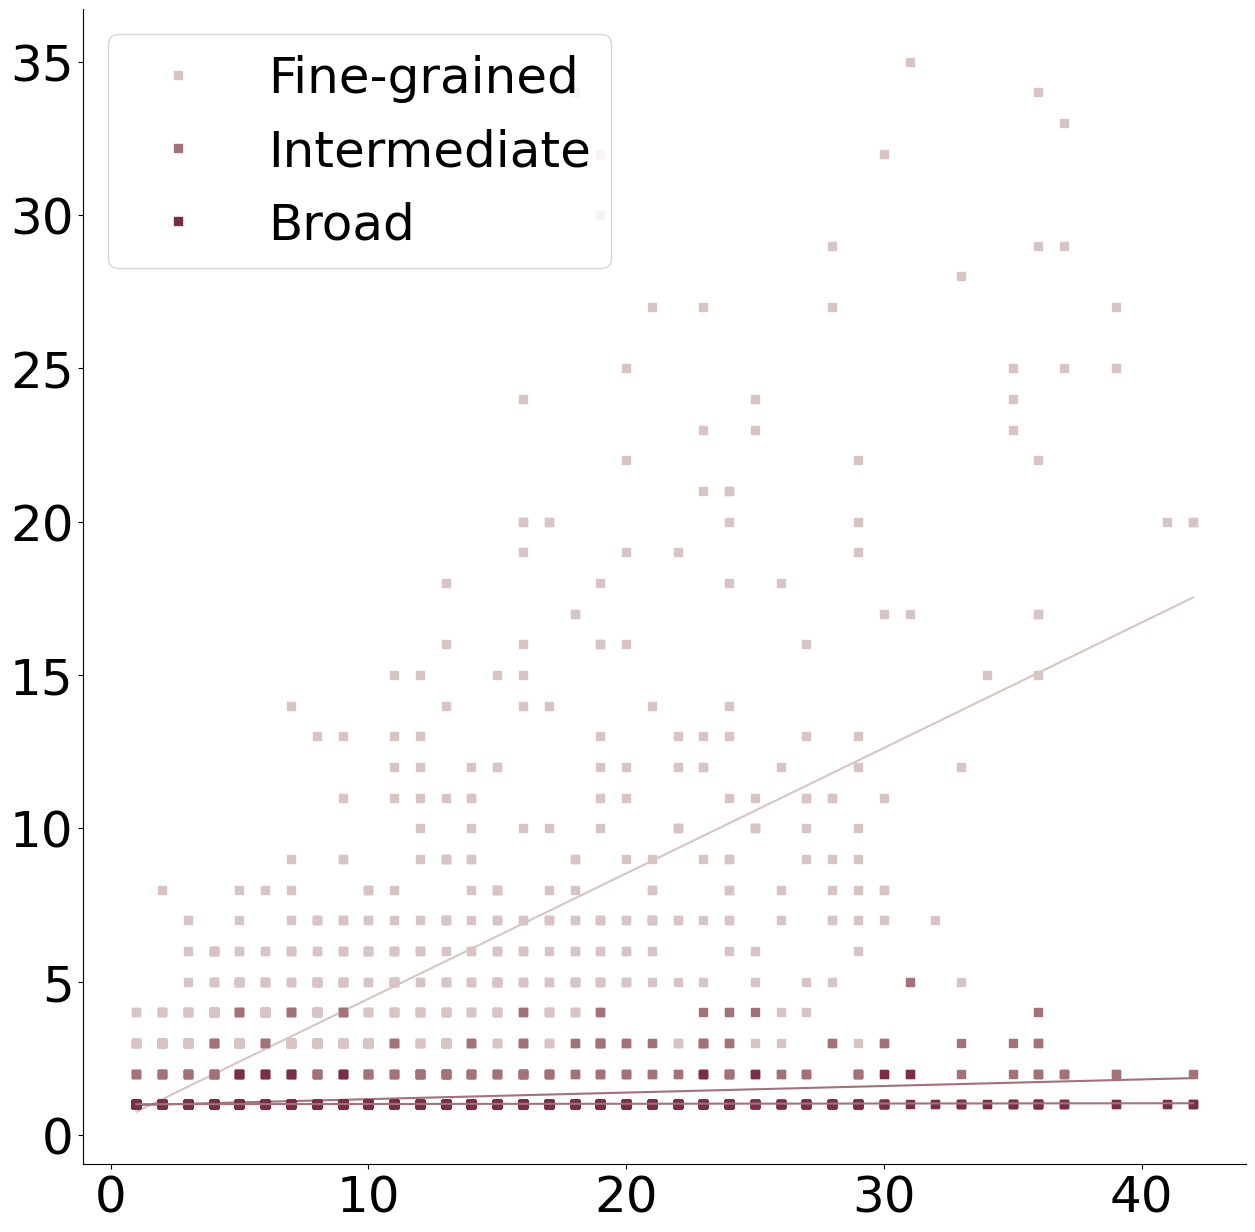

In [75]:
#Let's perform a correlation of the top frequently enriched exposures

import scipy
from matplotlib.pyplot import figure
from scipy import stats



fig, ax = plt.subplots(figsize=(15,15))
slope, intercept, r, p, stderr = scipy.stats.linregress(sbm_exp_frequency_list_vsfg, fine_grained_infomap_communities)
print("Fine-grained:%s"%r)

ax.plot(sbm_exp_frequency_list_vsfg,fine_grained_infomap_communities, linewidth=0, marker='s',c='#D8C4C5', label='Fine-grained')
y=[]
for i in sbm_exp_frequency_list_vsfg:
    g=(intercept + slope * i)
    y.append(g)
line = "Fine-grained" 

ax.plot(sbm_exp_frequency_list_vsfg, y,c='#D8C4C5')

slope, intercept, r, p, stderr = scipy.stats.linregress(sbm_exp_frequency_list_vsm, middle_infomap_communities)
print("Intermediate:%s"%r)
ax.plot(sbm_exp_frequency_list_vsm,middle_infomap_communities, linewidth=0, marker='s',c='#A47179', label='Intermediate')
y=[]
for i in sbm_exp_frequency_list_vsm:
    g=(intercept + slope * i)
    y.append(g)
line = "Intermediate" 

ax.plot(sbm_exp_frequency_list_vsm, y,c='#A47179')

slope, intercept, r, p, stderr = scipy.stats.linregress(sbm_exp_frequency_list_vsb, broad_infomap_communities)
print("Broad:%s"%r)
ax.plot(sbm_exp_frequency_list_vsb,broad_infomap_communities, linewidth=0, marker='s',c='#7A2D45', label='Broad')

y=[]
for i in sbm_exp_frequency_list_vsb:
    g=(intercept + slope * i)
    y.append(g)
line = "Broad" 

ax.plot(sbm_exp_frequency_list_vsb, y,c='#A47179')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xticks(fontsize=36) 
plt.yticks(fontsize=36) 

ax.legend(facecolor='white',fontsize=36)
#plt.savefig('output/Correlation_Infomap_GGN_Enriched_Communities.pdf',format='pdf',dpi=300, bbox_inches = "tight")
#plt.savefig('output/Correlation_Infomap_GGN_Enriched_Communities.png',format='png',dpi=300, bbox_inches = "tight")
plt.show()

In [76]:
# ================================
# Build source data table
# ================================

records = []

# Fine-grained
for x, y in zip(sbm_exp_frequency_list_vsfg, fine_grained_infomap_communities):
    records.append({
        "Hierarchy": "Fine-grained",
        "SBM_frequency": x,
        "Infomap_frequency": y
    })

# Intermediate
for x, y in zip(sbm_exp_frequency_list_vsm, middle_infomap_communities):
    records.append({
        "Hierarchy": "Intermediate",
        "SBM_frequency": x,
        "Infomap_frequency": y
    })

# Broad
for x, y in zip(sbm_exp_frequency_list_vsb, broad_infomap_communities):
    records.append({
        "Hierarchy": "Broad",
        "SBM_frequency": x,
        "Infomap_frequency": y
    })

df_corr_source = pd.DataFrame(records)

print("Total data points:", len(df_corr_source))

# ================================
# Save into existing Source Data file
# ================================

out_file = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(out_file,
                    engine="openpyxl",
                    mode="a",
                    if_sheet_exists="replace") as writer:

    df_corr_source.to_excel(
        writer,
        sheet_name="SF29E",
        index=False
    )

print("Correlation source data saved successfully.")

Total data points: 19892
Correlation source data saved successfully.


In [77]:
#SBM Unipartite
significant_SBM_GGN_clustering_dict_genes = {}
for com,gene_set in SBM_GGN_communities_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene.items():
        raw_pval=float(overlap_set(set(gene_set), set(geneset), len(gene_map)))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()),0.05)
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_SBM_GGN_clustering_dict_genes[com]= significant_chem_class

In [78]:
sbm_exp_ggn_list = []
for com,exp_list in significant_SBM_GGN_clustering_dict_genes.items():
    for el in range(len(exp_list)):
        sbm_exp_ggn_list.append(exp_list[el][0])

from collections import (defaultdict,Counter)
sbm_exp_ggn_counter_dict = dict(Counter(sbm_exp_ggn_list).most_common())

In [79]:
sbm_exp_frequency_list_vssbm_ggn = []
sbm_ggn_communities = []

for exp,fr in sbm_exp_counter_dict.items():
    try:
        sbm_ggn_communities.append(sbm_exp_ggn_counter_dict[exp])
        sbm_exp_frequency_list_vssbm_ggn.append(fr)
    except:
        pass

SBM:0.7526012551209931


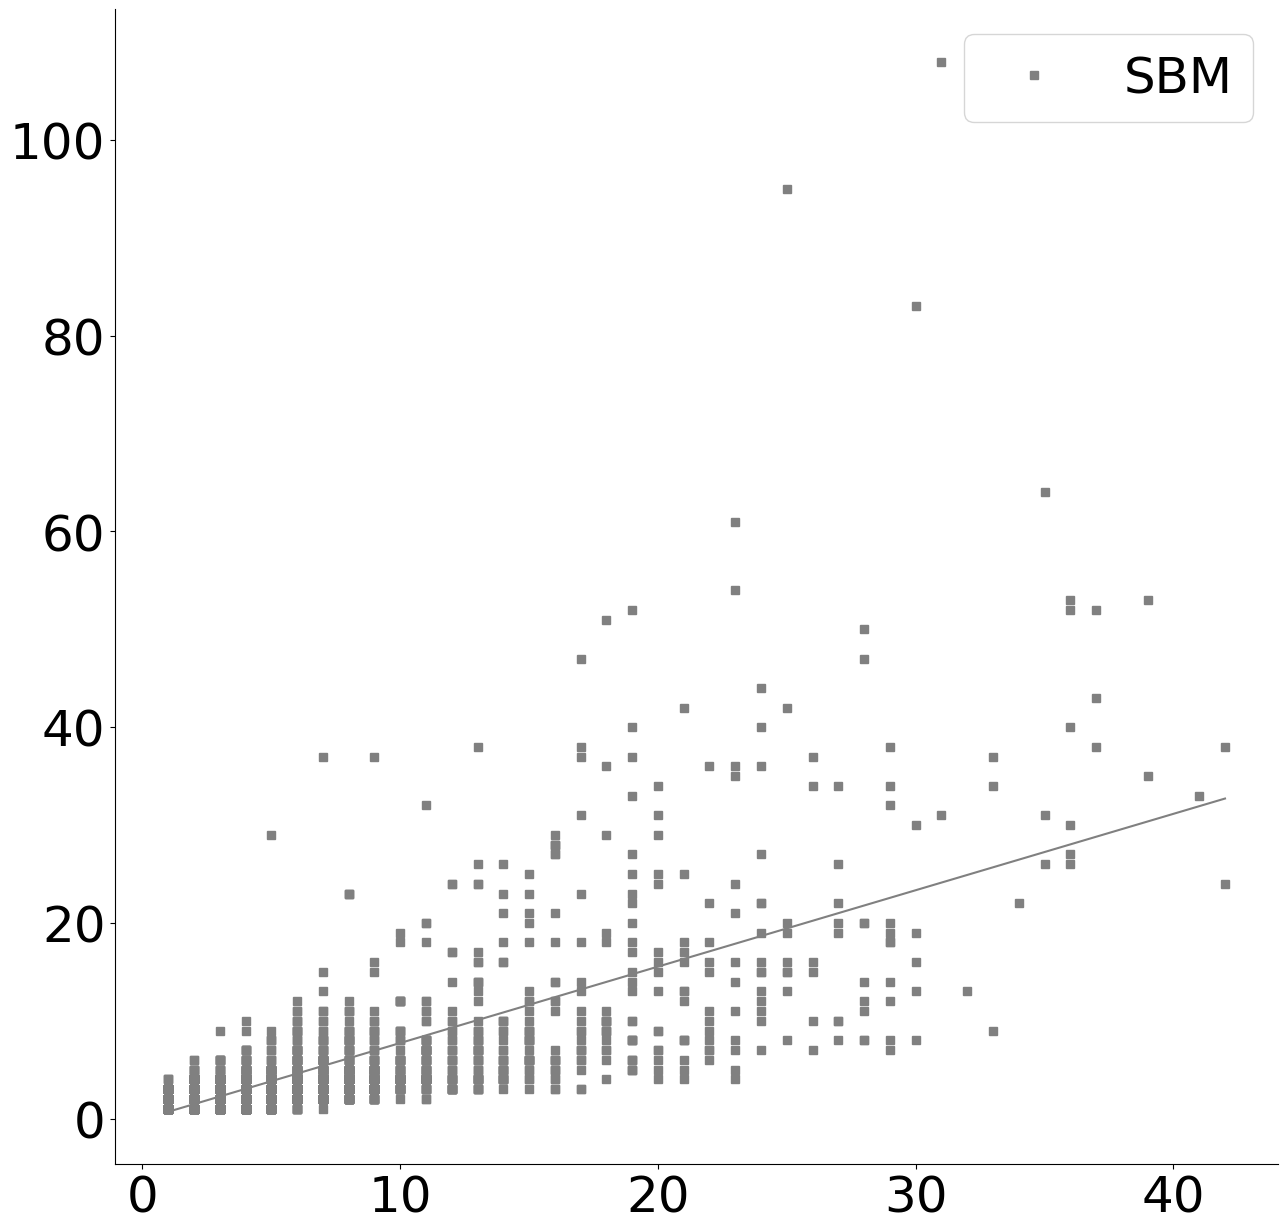

In [ ]:
#Let's perform a correlation of the top frequently enriched exposures

import scipy
from matplotlib.pyplot import figure
from scipy import stats




fig, ax = plt.subplots(figsize=(15,15))
slope, intercept, r, p, stderr = scipy.stats.linregress(sbm_exp_frequency_list_vssbm_ggn, sbm_ggn_communities)
print("SBM:%s"%r)

ax.plot(sbm_exp_frequency_list_vssbm_ggn,sbm_ggn_communities, linewidth=0, marker='s',c='grey', label='SBM')
y=[]
for i in sbm_exp_frequency_list_vssbm_ggn:
    g=(intercept + slope * i)
    y.append(g)
line = "SBM" 
ax.plot(sbm_exp_frequency_list_vssbm_ggn, y,c='grey')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xticks(fontsize=36) 
plt.yticks(fontsize=36) 

ax.legend(facecolor='white',fontsize=36)
plt.savefig('output/Correlation_SBM_GGN_Enriched_Communities.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.savefig('output/Correlation_SBM_GGN_Enriched_Communities.png',format='png',dpi=300, bbox_inches = "tight")
plt.show()

In [80]:
# ================================
# Build source data table
# ================================


records = []


# Fine-grained
for x, y in zip(sbm_exp_frequency_list_vssbm_ggn, sbm_ggn_communities):
    records.append({
        "SBM_frequency": x,
        "SBM_EEN_frequency": y
    })

df_corr_source = pd.DataFrame(records)

print("Total data points:", len(df_corr_source))

# ================================
# Save into existing Source Data file
# ================================

out_file = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(out_file,
                    engine="openpyxl",
                    mode="a",
                    if_sheet_exists="replace") as writer:

    df_corr_source.to_excel(
        writer,
        sheet_name="SF29F",
        index=False
    )

print("Correlation source data saved successfully.")

Total data points: 7730
Correlation source data saved successfully.


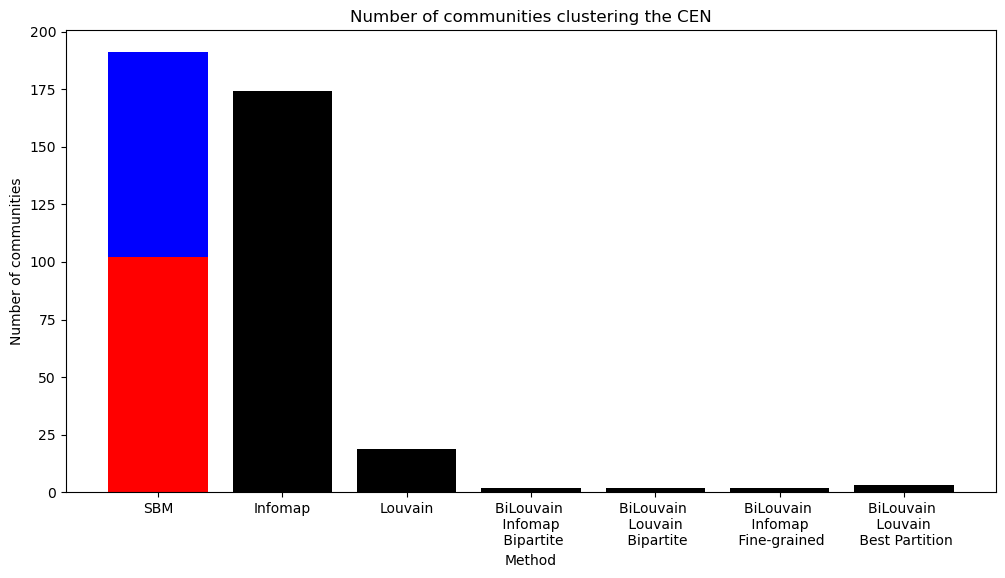

In [338]:

# Data for the stacked bar
data = [191,174, 19, 2, 2, 2,3]
sbm_stacked_data = [102, 89]


# Labels for the x-axis
labels = ['SBM','Infomap', 'Louvain', 'BiLouvain \n Infomap \n Bipartite', 
          'BiLouvain \n Louvain \n Bipartite', 
          'BiLouvain \n Infomap \n Fine-grained',
          'BiLouvain \n Louvain \n Best Partition'
         ]

fig, ax = plt.subplots(figsize=(12, 6))

# Create the stacked bar for the first element
ax.bar(labels[0], sbm_stacked_data[0], color='red')  # Add the bottom part (red)
ax.bar(labels[0], sbm_stacked_data[1], bottom=sbm_stacked_data[0], color='blue')  # Add the top part (blue)

# Create the rest of the bars
ax.bar(labels[1:], data[1:], color='black')

# Add titles and labels
plt.xlabel('Method')
plt.ylabel('Number of communities')
plt.title('Number of communities clustering the CEN')

plt.savefig('output/SupplementaryFig8_Reviewd.pdf',format='pdf',dpi=300, bbox_inches = "tight")
# Display the plot
plt.show()